In [1]:
import sys
sys.path.append('../../src')
import pandas
import random
import math
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, ProcessMode, VaryingProcess
from energiapy.components.location import Location
from energiapy.components.transport import Transport
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
from energiapy.model.constraints.demand import constraint_demand2
from energiapy.components.result import Result
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario, plot_location
from energiapy.model.solve import solve
from pyomo.environ import Param
from energiapy.utils.scale_utils import scale_pyomo_set

In [2]:
_time_intervals = 30  # Number of time intervals in a planning horizon    (L_chi)
_coms = 1
_exec_scenarios = 12  # Number of execution scenarios                     (chi)

M = 1e3  # Big M

init = [1]

# loc1_avail_list = init*3+[math.ceil(random.uniform(0,0.25)*100)/100.0 for _ in range (_exec_scenarios-3)]

loc2_varying_factor = pandas.DataFrame(data={'com1_store20': [1, 1, 1, 0.19, 0.04, 0.09, 0.13, 0.19, 0.12, 0.01, 0.13, 0.17],
                                             'com1_discharge20': [1, 1, 1, 0.19, 0.04, 0.09, 0.13, 0.19, 0.12, 0.01, 0.13, 0.17],
                                             'com1_process': [1, 1, 1, 0.19, 0.04, 0.09, 0.13, 0.19, 0.12, 0.01, 0.13, 0.17]})

loc3_varying_factor = pandas.DataFrame(data={'com1_store20': [1, 1, 1, 1, 1, 1, 0.12, 0.06, 0.16, 0.25, 0.18, 0.17],
                                             'com1_discharge20': [1, 1, 1, 1, 1, 1, 0.12, 0.06, 0.16, 0.25, 0.18, 0.17],
                                             'com1_process': [1, 1, 1, 1, 1, 1, 0.12, 0.06, 0.16, 0.25, 0.18, 0.17]})

loc7_varying_factor = pandas.DataFrame(data={'com1_store20': [1, 1, 1, 1, 1, 1, 1, 1, 1, 0.14, 0.24, 0.04],
                                             'com1_discharge20': [1, 1, 1, 1, 1, 1, 1, 1, 1, 0.14, 0.24, 0.04],
                                             'com1_process': [1, 1, 1, 1, 1, 1, 1, 1, 1, 0.14, 0.24, 0.04]})

# loc2_varying_factor = pandas.DataFrame(data={'com1_store20': init*3+[0]*(_exec_scenarios-3),
#                                              'com1_discharge20': init*3+[0]*(_exec_scenarios-3),
#                                              'com1_process': init*3+[0]*(_exec_scenarios-3)})
# 
# loc3_varying_factor = pandas.DataFrame(data={'com1_store20': init*6+[0]*(_exec_scenarios-6),
#                                              'com1_discharge20': init*6+[0]*(_exec_scenarios-6),
#                                              'com1_process': init*6+[0]*(_exec_scenarios-6)})
# 
# loc7_varying_factor = pandas.DataFrame(data={'com1_store20': init*9+[0]*(_exec_scenarios-9),
#                                              'com1_discharge20': init*9+[0]*(_exec_scenarios-9),
#                                              'com1_process': init*9+[0]*(_exec_scenarios-9)})

# Define temporal scales
scales = TemporalScale(discretization_list=[1, _exec_scenarios, _time_intervals])

demand_factor = [1]*_exec_scenarios

In [3]:
# loc1_avail_list

In [4]:
# ======================================================================================================================
# Declare resources/commodities
# ======================================================================================================================

com1_pur = Resource(name='com1_pur', cons_max=200, block={'imp': 1, 'urg': 1}, price=0.00,
                    label='Commodity 1 consumed from outside the system')

com1_in = Resource(name='com1_in', label='Commodity 1 received')

com1_stored10 = Resource(name='com1_stored10', store_max=10, label='Commodity 1 in storage10')
com1_stored20 = Resource(name='com1_stored20', store_max=20, label='Commodity 1 in storage20')
com1_stored50 = Resource(name='com1_stored50', store_max=50, label='Commodity 1 in storage50')

com1_out = Resource(name='com1_out', label='Commodity 1 to be sent out')

com1_loc1_out = Resource(name='com1_loc1_out', label='Commodity 1 sent out from location 1')
com1_loc2_out = Resource(name='com1_loc2_out', label='Commodity 1 sent out from location 2')
com1_loc3_out = Resource(name='com1_loc3_out', label='Commodity 1 sent out from location 3')
com1_loc4_out = Resource(name='com1_loc4_out', label='Commodity 1 sent out from location 4')
com1_loc6_out = Resource(name='com1_loc6_out', label='Commodity 1 sent out from location 6')
com1_loc7_out = Resource(name='com1_loc7_out', label='Commodity 1 sent out from location 7')

com1_sold = Resource(name='com1_sold', revenue=0.00, demand=True, sell=True, label='Commodity 1 sold to outside the system')

In [5]:
# ======================================================================================================================
# Declare processes/storage capacities
# ======================================================================================================================
com1_procure = Process(name='procure com1', prod_max=150, conversion={com1_pur: -1, com1_in: 1}, capex=0.1, vopex=0.1, fopex=0.1,
                  label='Procure com1')
com1_sell = Process(name='sell com1', prod_max=M, conversion={com1_out: -1, com1_sold: 1}, capex=0.1, vopex=0.1, fopex=0.1,
                  label='Sell com1')

com1_receive_loc1 = Process(name='com1_receive_loc1', prod_max=125, conversion={com1_loc1_out:-1, com1_in:1}, capex=0.1, vopex=0.1, fopex=0.1,
                            label='Commodity 1 received from location 1')
com1_receive_loc2 = Process(name='com1_receive_loc2', prod_max=125, conversion={com1_loc2_out:-1, com1_in:1}, capex=0.1, vopex=0.1, fopex=0.1,
                            label='Commodity 1 received from location 2')
com1_receive_loc3 = Process(name='com1_receive_loc3', prod_max=125, conversion={com1_loc3_out:-1, com1_in:1}, capex=0.1, vopex=0.1, fopex=0.1,
                            label='Commodity 1 received from location 3')
com1_receive_loc4 = Process(name='com1_receive_loc4', prod_max=125, conversion={com1_loc4_out:-1, com1_in:1}, capex=0.1, vopex=0.1, fopex=0.1,
                            label='Commodity 1 received from location 4')
com1_receive_loc6 = Process(name='com1_receive_loc6', prod_max=125, conversion={com1_loc6_out:-1, com1_in:1}, capex=0.1, vopex=0.1, fopex=0.1,
                            label='Commodity 1 received from location 6')
com1_receive_loc7 = Process(name='com1_receive_loc7', prod_max=125, conversion={com1_loc7_out:-1, com1_in:1}, capex=0.1, vopex=0.1, fopex=0.1,
                            label='Commodity 1 received from location 7')

com1_process = Process(name='com1_process', prod_max=125, conversion={com1_in:-1, com1_out:1}, capex=0.1, vopex=0.1, fopex=0.1, varying=[VaryingProcess.DETERMINISTIC_CAPACITY],
                            label='Process the commodity through the location')

com1_store10 = Process(name='com1_store10', conversion={com1_in:-1, com1_stored10:1}, prod_max=125, capex=100, vopex=1,
                  label="Storage capacity of 10 units")
com1_discharge10 = Process(name='com1_discharge10', conversion={com1_stored10:-1, com1_out:1},  prod_max=125,
                                 label='Discharge process from storage')

com1_store20 = Process(name='com1_store20', conversion={com1_in:-1, com1_stored20:1}, prod_max=125, capex=125, vopex=2, varying=[VaryingProcess.DETERMINISTIC_CAPACITY],
                  label="Storage capacity of 20 units")
com1_discharge20 = Process(name='com1_discharge20', conversion={com1_stored20:-1, com1_out:1}, prod_max=125, varying=[VaryingProcess.DETERMINISTIC_CAPACITY],
                                 label='Discharge process from storage')

com1_store50 = Process(name='com1_store50', conversion={com1_in:-1, com1_stored50:1}, prod_max=125, capex=500, vopex=5,
                  label="Storage capacity of 50 units")
com1_discharge50 = Process(name='com1_discharge50', conversion={com1_stored50:-1, com1_out:1}, prod_max=125,
                                 label='Discharge process from storage')

com1_loc1_send = Process(name='com1_loc1_send', prod_max=125, conversion={com1_out:-1, com1_loc1_out:1}, capex=0.1, vopex=0.1, fopex=0.1,
                            label='Send commodity one from location 1')
com1_loc2_send = Process(name='com1_loc2_send', prod_max=125, conversion={com1_out:-1, com1_loc2_out:1}, capex=0.1, vopex=0.1, fopex=0.1,
                            label='Send commodity one from location 1')
com1_loc3_send = Process(name='com1_loc3_send', prod_max=125, conversion={com1_out:-1, com1_loc3_out:1}, capex=0.1, vopex=0.1, fopex=0.1,
                            label='Send commodity one from location 1')
com1_loc4_send = Process(name='com1_loc4_send', prod_max=125, conversion={com1_out:-1, com1_loc4_out:1}, capex=0.1, vopex=0.1, fopex=0.1,
                            label='Send commodity one from location 1')
com1_loc6_send = Process(name='com1_loc6_send', prod_max=125, conversion={com1_out:-1, com1_loc6_out:1}, capex=0.1, vopex=0.1, fopex=0.1,
                            label='Send commodity one from location 1')
com1_loc7_send = Process(name='com1_loc7_send', prod_max=125, conversion={com1_out:-1, com1_loc7_out:1}, capex=0.1, vopex=0.1, fopex=0.1,
                            label='Send commodity one from location 1')


In [6]:
# ======================================================================================================================
# Declare locations/warehouses
# ======================================================================================================================
loc1 = Location(name='loc1', processes={com1_procure, com1_process, com1_store20, com1_discharge20, com1_loc1_send}, label="Location 1", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

loc2 = Location(name='loc2', processes={com1_receive_loc1, com1_process, com1_store20, com1_discharge20, com1_loc2_send}, label="Location 2", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1, capacity_factor={com1_store20: loc2_varying_factor[['com1_store20']], com1_discharge20: loc2_varying_factor[['com1_discharge20']], com1_process: loc2_varying_factor[['com1_process']]})

loc3 = Location(name='loc3', processes={com1_receive_loc1, com1_process, com1_store20, com1_discharge20, com1_loc3_send}, label="Location 3", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1, capacity_factor={com1_store20: loc3_varying_factor[['com1_store20']], com1_discharge20: loc3_varying_factor[['com1_discharge20']], com1_process: loc3_varying_factor[['com1_process']]})

loc4 = Location(name='loc4', processes={com1_receive_loc2, com1_receive_loc3, com1_receive_loc6, com1_process, com1_store50, com1_discharge50, com1_loc4_send}, label="Location 4", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

loc5 = Location(name='loc5', processes={com1_receive_loc2, com1_receive_loc4, com1_receive_loc7, com1_process, com1_store50, com1_discharge50, com1_sell,}, label="Location 5", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

loc6 = Location(name='loc6', processes={com1_procure, com1_process, com1_store10, com1_discharge10, com1_loc6_send}, label="Location 6", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

loc7 = Location(name='loc7', processes={com1_receive_loc4, com1_process, com1_store20, com1_discharge20, com1_loc7_send}, label="Location 7", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1, capacity_factor={com1_store20: loc7_varying_factor[['com1_store20']], com1_discharge20: loc7_varying_factor[['com1_discharge20']], com1_process: loc7_varying_factor[['com1_process']]})

In [7]:
# ======================================================================================================================
# Declare transport/trucks
# ======================================================================================================================
truck20_34 = Transport(name='truck20_34', resources={com1_loc3_out}, trans_max=20, label='Truck with maximum capacity of 20 units', capex=20, vopex=0.02, trans_min=0.01)
truck30_13 = Transport(name='truck30_13', resources={com1_loc1_out}, trans_max=30, label='Truck with maximum capacity of 30 units', capex=30, vopex=0.03, trans_min=0.01)
truck30_25 = Transport(name='truck30_25', resources={com1_loc2_out}, trans_max=30, label='Truck with maximum capacity of 30 units', capex=30, vopex=0.03, trans_min=0.01)
truck40_47 = Transport(name='truck40_47', resources={com1_loc4_out}, trans_max=40, label='Truck with maximum capacity of 40 units', capex=40, vopex=0.04, trans_min=0.01)
truck40_75 = Transport(name='truck40_75', resources={com1_loc7_out}, trans_max=40, label='Truck with maximum capacity of 40 units', capex=40, vopex=0.04, trans_min=0.01)
truck50_12 = Transport(name='truck50_12', resources={com1_loc1_out}, trans_max=50, label='Truck with maximum capacity of 50 units', capex=50, vopex=0.05, trans_min=0.01)
truck50_24 = Transport(name='truck50_24', resources={com1_loc2_out}, trans_max=50, label='Truck with maximum capacity of 50 units', capex=50, vopex=0.05, trans_min=0.01)
truck50_64 = Transport(name='truck50_64', resources={com1_loc6_out}, trans_max=50, label='Truck with maximum capacity of 50 units', capex=50, vopex=0.05, trans_min=0.01)
truck100_45 = Transport(name='truck100_45', resources={com1_loc4_out}, trans_max=100, label='Truck with maximum capacity of 100 units', capex=100, vopex=0.1, trans_min=0.01)

In [8]:
# ======================================================================================================================
# Declare network
# ======================================================================================================================
transport_matrix = [
    [[], [truck50_12], [truck30_13], [], [], [], []],  # source: location 1
    [[], [], [], [truck50_24], [truck30_25], [], []],  # source: location 2
    [[], [], [], [truck20_34], [], [], []],  # source: location 3
    [[], [], [], [], [truck100_45], [], [truck40_47]],  # source: location 4
    [[], [], [], [], [], [], []],  # source: location 5
    [[], [], [], [truck50_64], [], [], []],  # source: location 6
    [[], [], [], [], [truck40_75], [], []]  # source: location 7
]

distance_matrix = [
    [0, 55, 196, M, M, M, M],
    [55, 0, M, 163, 112, M, 134],
    [196, M, 0, 63, M, M, M],
    [M, 163, 63, 0, 95, 117, 88],
    [M, 112, M, 95, 0, M, 134],
    [M, M, M, 117, M, 0, M],
    [M, 134, M, 88, 134, M, 0]
]

locset = [loc1, loc2, loc3, loc4, loc5, loc6, loc7]

sources = locset
sinks = locset

network = Network(name='Network', scales= scales, source_locations=sources, sink_locations=sinks, transport_matrix=transport_matrix, distance_matrix=distance_matrix)

In [9]:
demand_dict = {i: {com1_sold: 100} if i == loc5 else {com1_sold: 0} for i in locset}
demand_penalty_dict = {i: {com1_sold: 125} if i == loc5 else {com1_sold: 0} for i in locset}
min_demand_satisfaction = 0.20
min_demand_dict = {i: {com1_sold: min_demand_satisfaction*100} if i == loc5 else {com1_sold: 0} for i in locset}

scenario_disruption = Scenario(name='scenario_disruption', scales=scales, scheduling_scale_level=2, network_scale_level=0, purchase_scale_level=2, availability_scale_level=1, demand_scale_level=2, capacity_scale_level=1,
                    network=network, demand=demand_dict, demand_penalty=demand_penalty_dict, label='scenario_disruption')

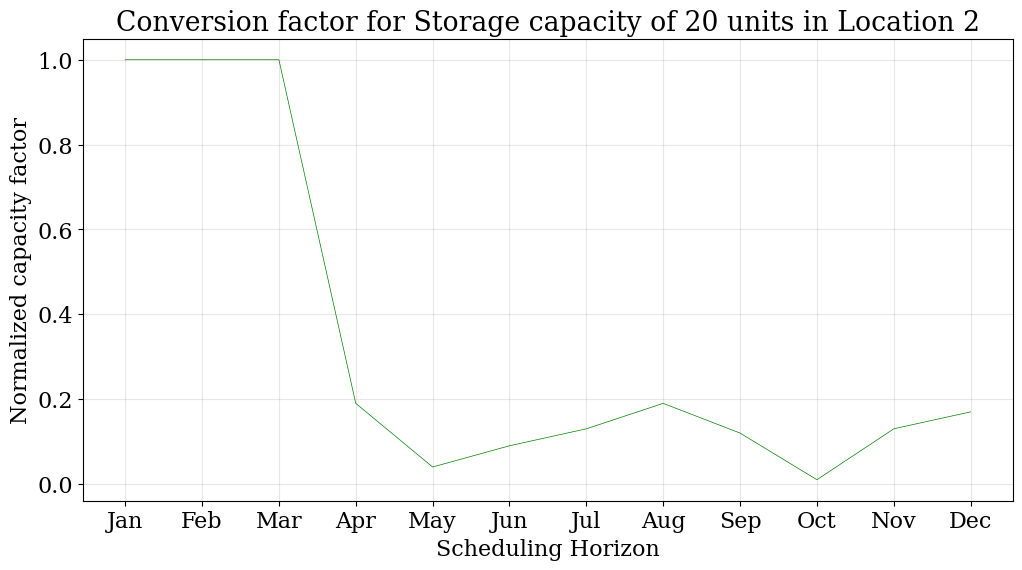

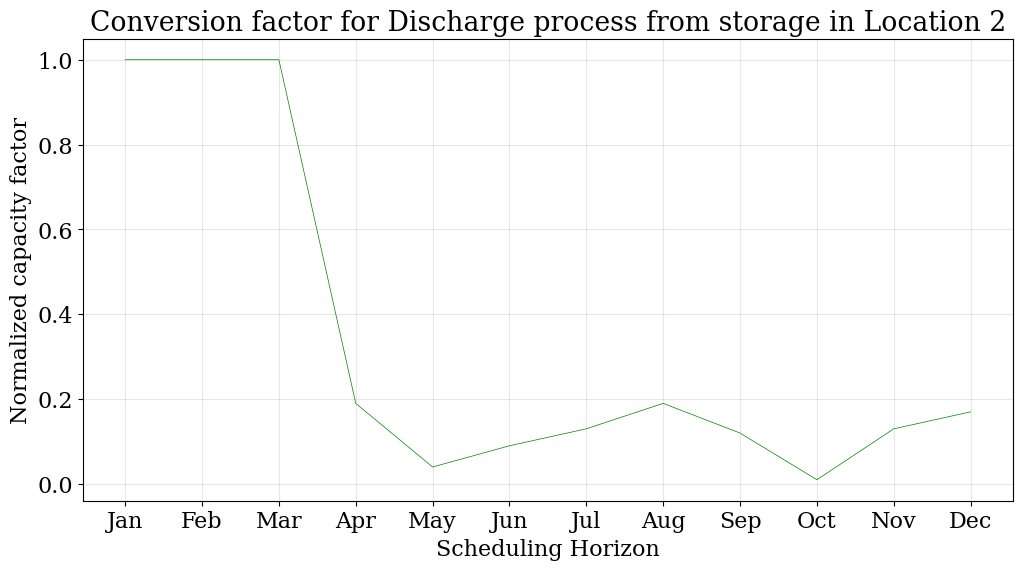

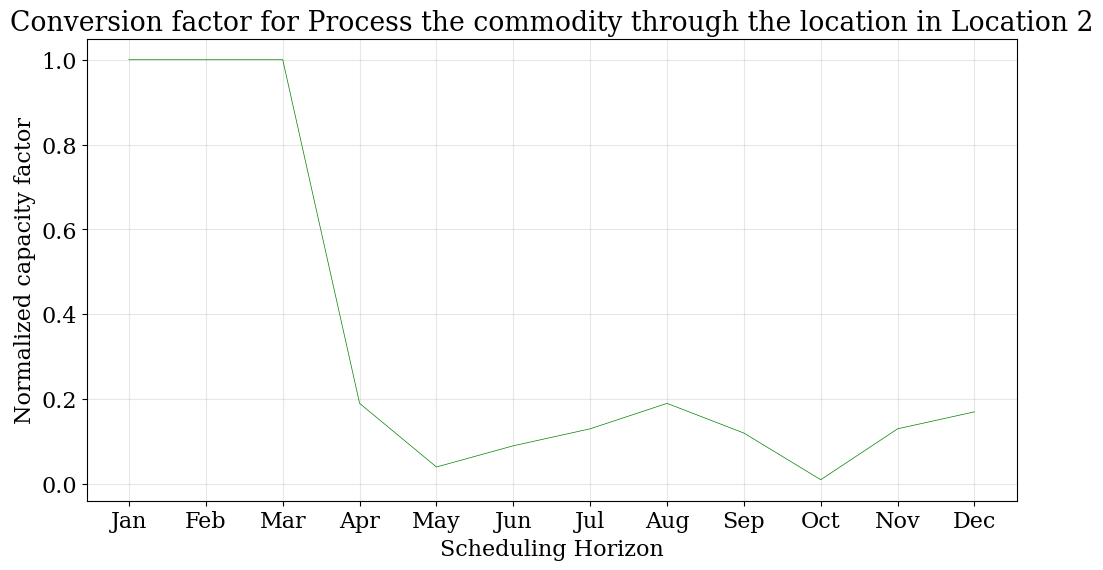

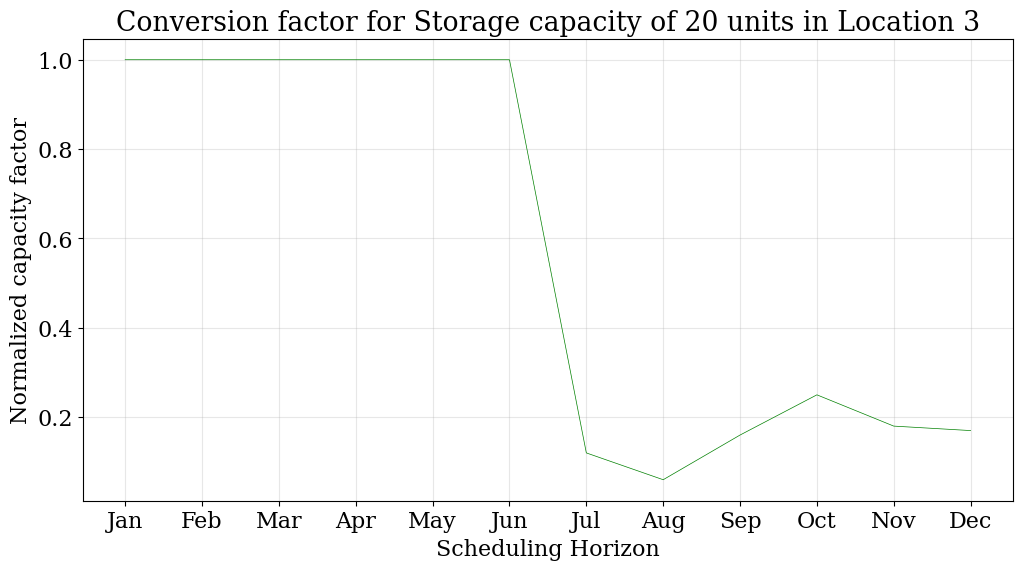

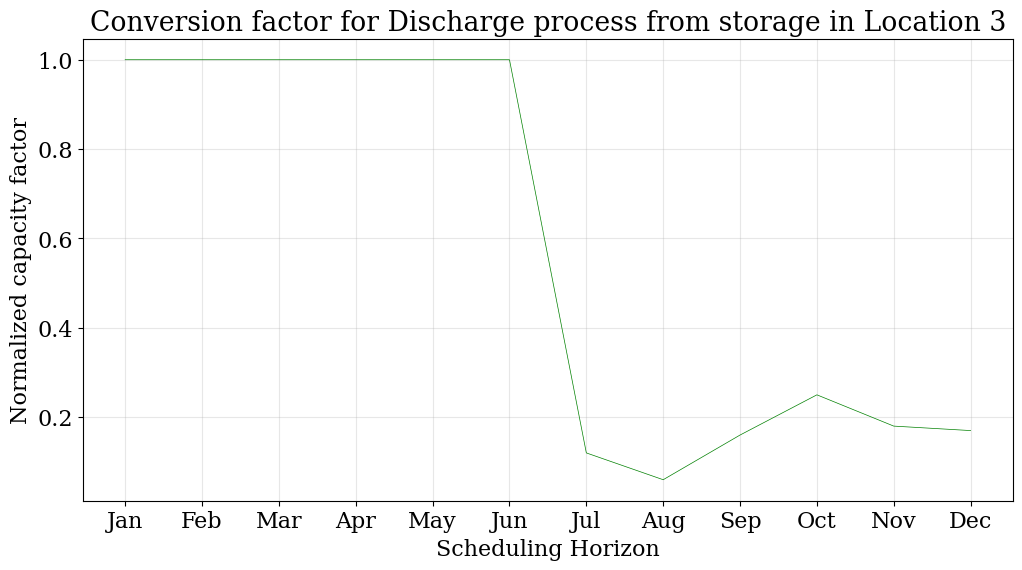

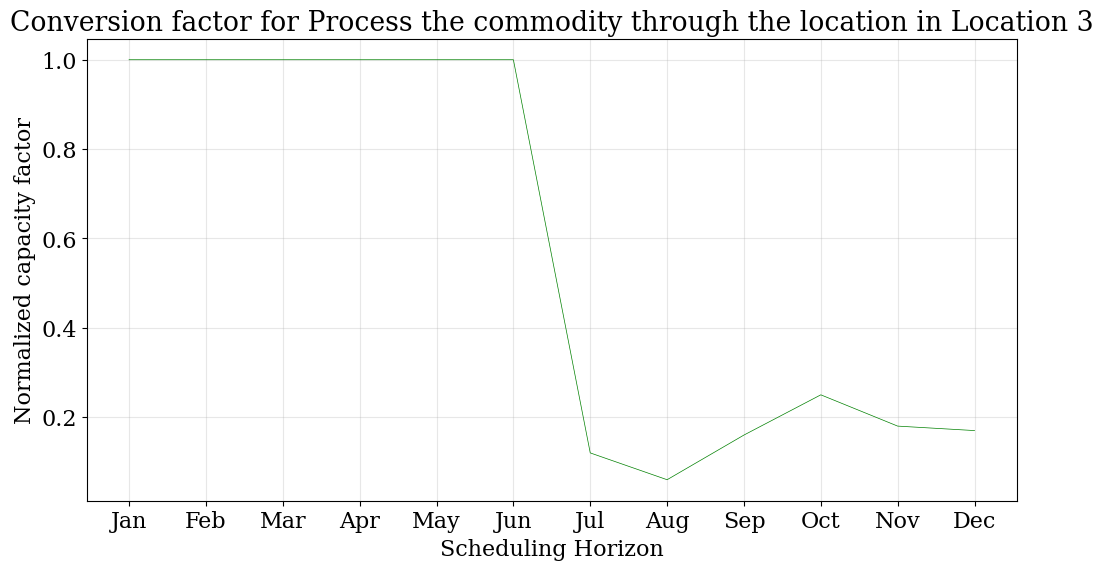

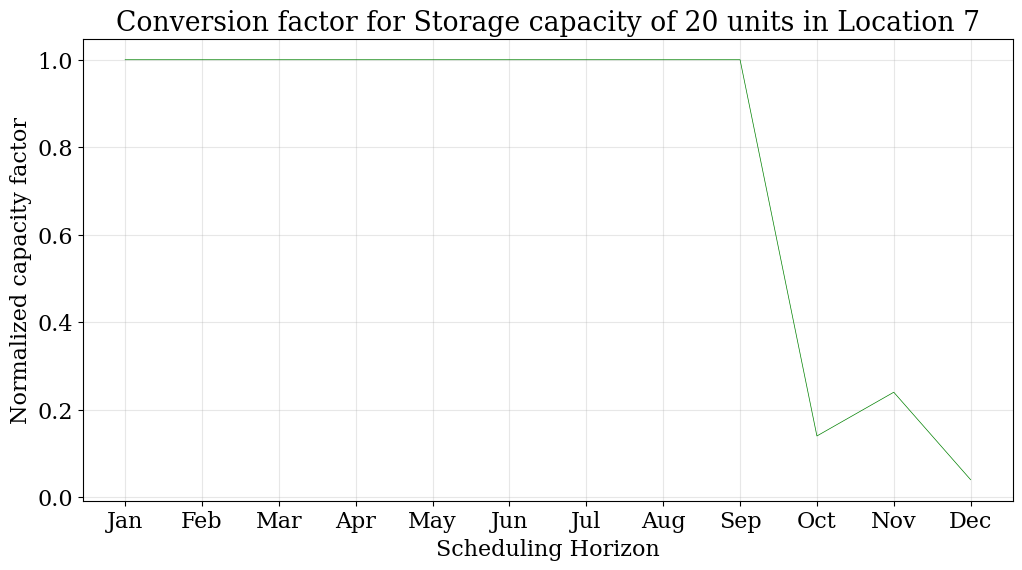

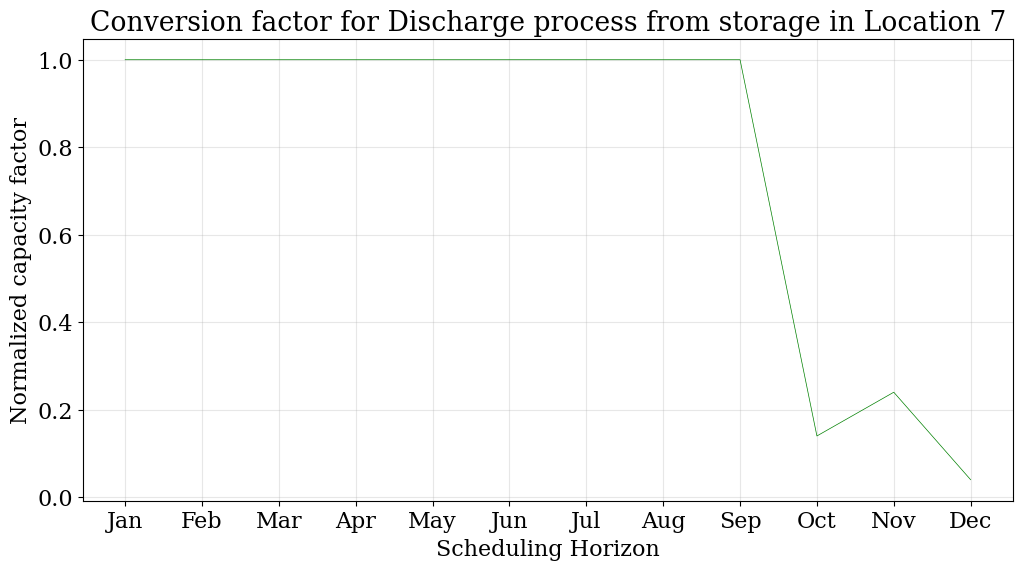

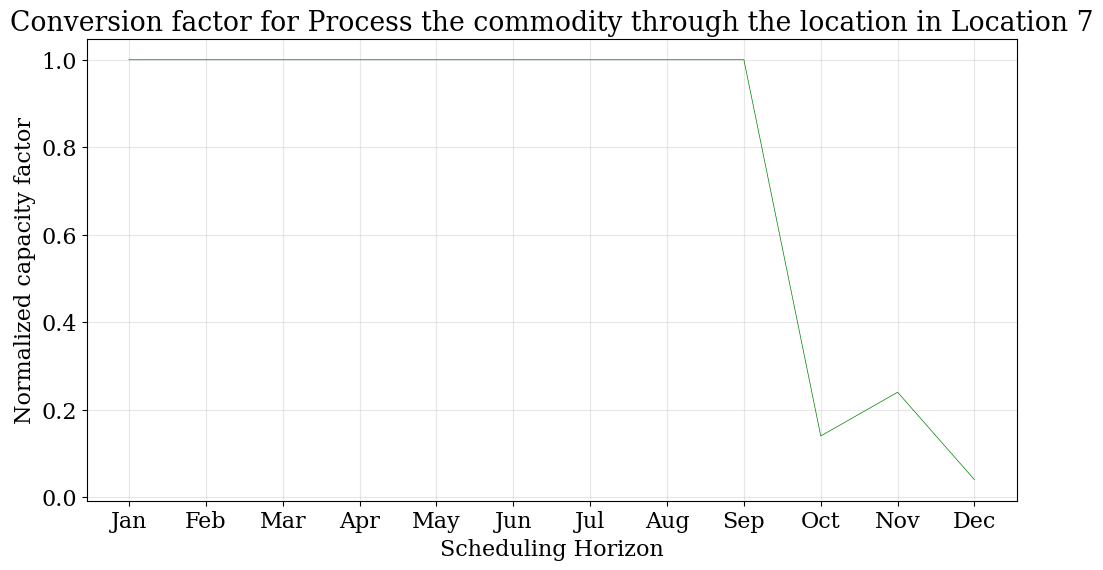

In [10]:
plot_scenario.capacity_factor(scenario=scenario_disruption, process=com1_store20, location=loc2, color='green')
plot_scenario.capacity_factor(scenario=scenario_disruption, process=com1_discharge20, location=loc2, color='green')
plot_scenario.capacity_factor(scenario=scenario_disruption, process=com1_process, location=loc2, color='green')
plot_scenario.capacity_factor(scenario=scenario_disruption, process=com1_store20, location=loc3, color='green')
plot_scenario.capacity_factor(scenario=scenario_disruption, process=com1_discharge20, location=loc3, color='green')
plot_scenario.capacity_factor(scenario=scenario_disruption, process=com1_process, location=loc3, color='green')
plot_scenario.capacity_factor(scenario=scenario_disruption, process=com1_store20, location=loc7, color='green')
plot_scenario.capacity_factor(scenario=scenario_disruption, process=com1_discharge20, location=loc7, color='green')
plot_scenario.capacity_factor(scenario=scenario_disruption, process=com1_process, location=loc7, color='green')

In [11]:
problem_mincost = formulate(scenario=scenario_disruption,
                            constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.NETWORK, Constraints.RESOURCE_BALANCE,
                                         Constraints.INVENTORY, Constraints.PRODUCTION,  Constraints.DEMAND},
                            demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint production mode
constraint inventory balance
constraint resource export
constraint transport export
constraint export
constraint transport capacity UB
constraint transport capacity LB
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand penalty
objective cost w demand penalty


In [12]:
results_mincost = solve(scenario=scenario_disruption, instance=problem_mincost, solver='gurobi', name='MILP')

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 425511 rows, 1346975 columns and 686876 nonzeros
Model fingerprint: 0x4e4e5e12
Variable types: 1346366 continuous, 609 integer (609 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+04]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+03]
Found heuristic solution: objective 4500000.0000
Presolve removed 405337 rows and 1334689 columns
Presolve time: 0.54s
Presolved: 20174 rows, 12286 columns, 56182 nonzeros
Variable types: 12277 continuous, 9 integer (9 binary)

Root relaxation: objective 2.020591e+06, 17524 iterations, 1.33 seconds (2.10 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     

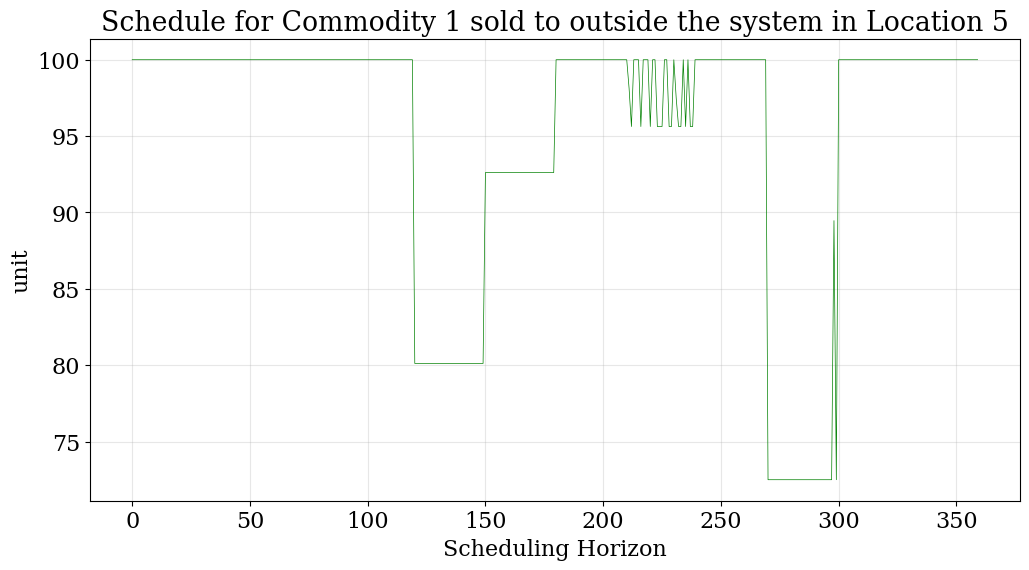

In [13]:
plot_results.schedule(results=results_mincost, y_axis='S', component='com1_sold', location='loc5', color='green')

In [14]:
sum(value for key, value in results_mincost.output['Demand_penalty'].items() if key[0]=='loc5' and key[1]=='com1_sold')

1687.4999999999955

In [15]:
sum(value for key, value in results_mincost.output['Demand_penalty'].items() if key[0]=='loc5' and key[1]=='com1_sold')*2500

4218749.999999989

In [16]:
results_mincost.output['objective']-sum(value for key, value in results_mincost.output['Demand_penalty'].items() if key[0]=='loc5' and key[1]=='com1_sold')*2500

-2198158.9577228203

In [17]:
sum(value for key, value in results_mincost.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold')

34312.500000000015

In [18]:
sum(value for key, value in results_mincost.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold') / 36000

0.9531250000000004

In [19]:
min(value for key, value in results_mincost.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold')

72.5

In [20]:
print([(key, value) for key, value in results_mincost.output['X_P'].items() if value==1 and key[0]=='loc1'])

[(('loc1', 'com1_discharge20', 0), 1.0), (('loc1', 'com1_loc1_send', 0), 1.0), (('loc1', 'com1_process', 0), 1.0), (('loc1', 'com1_store20', 0), 1.0), (('loc1', 'procure com1', 0), 1.0)]


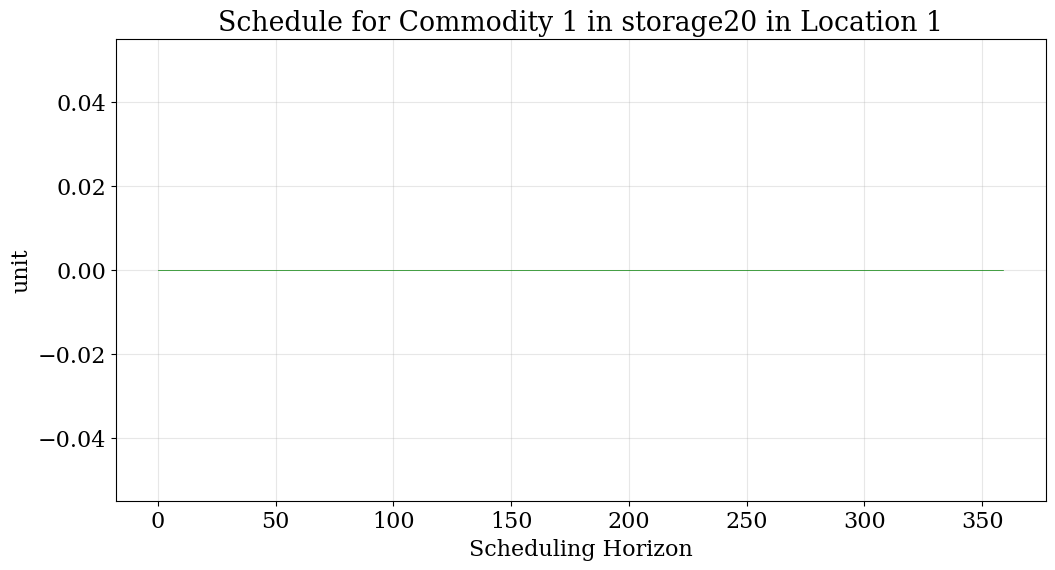

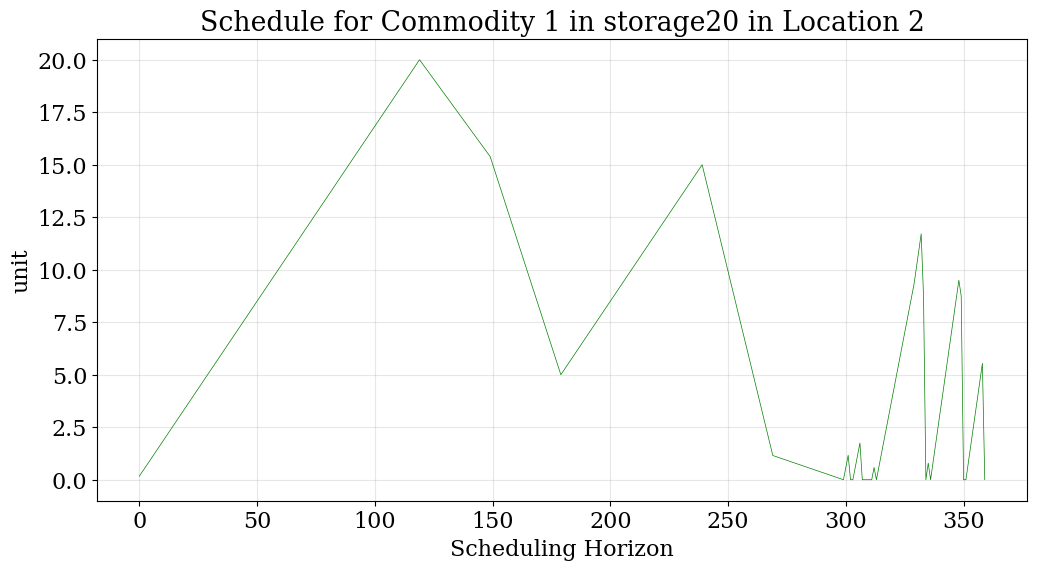

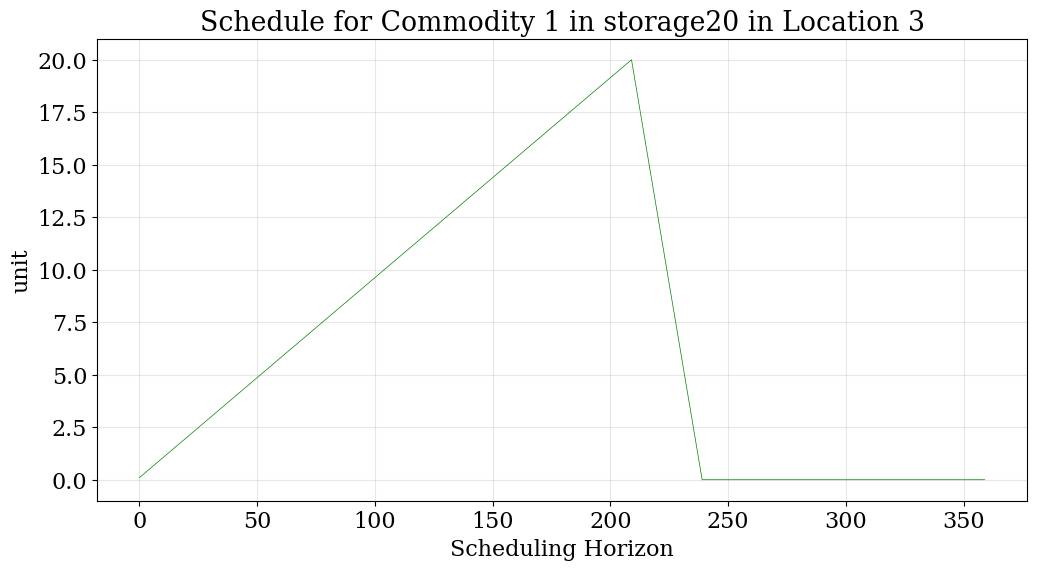

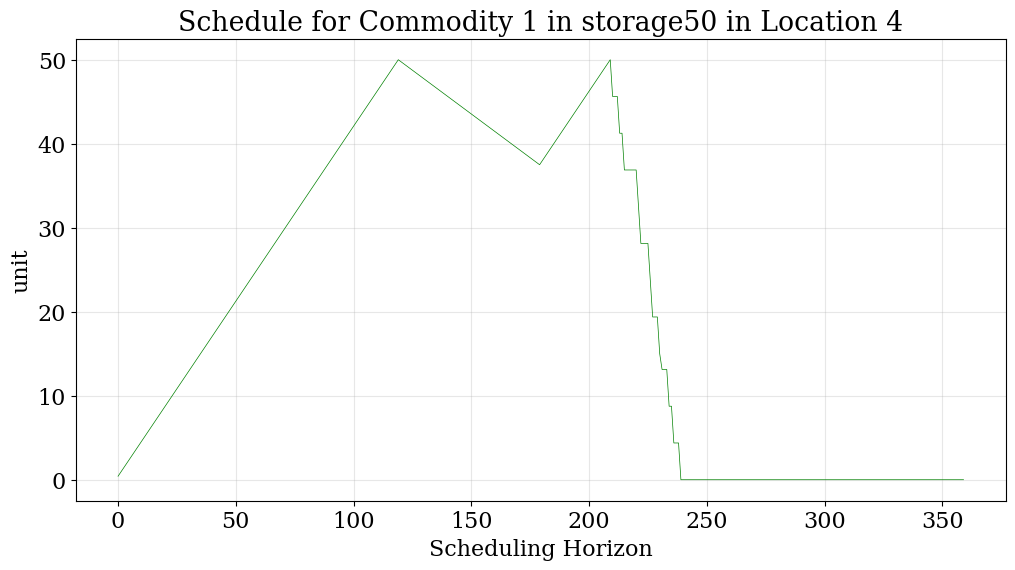

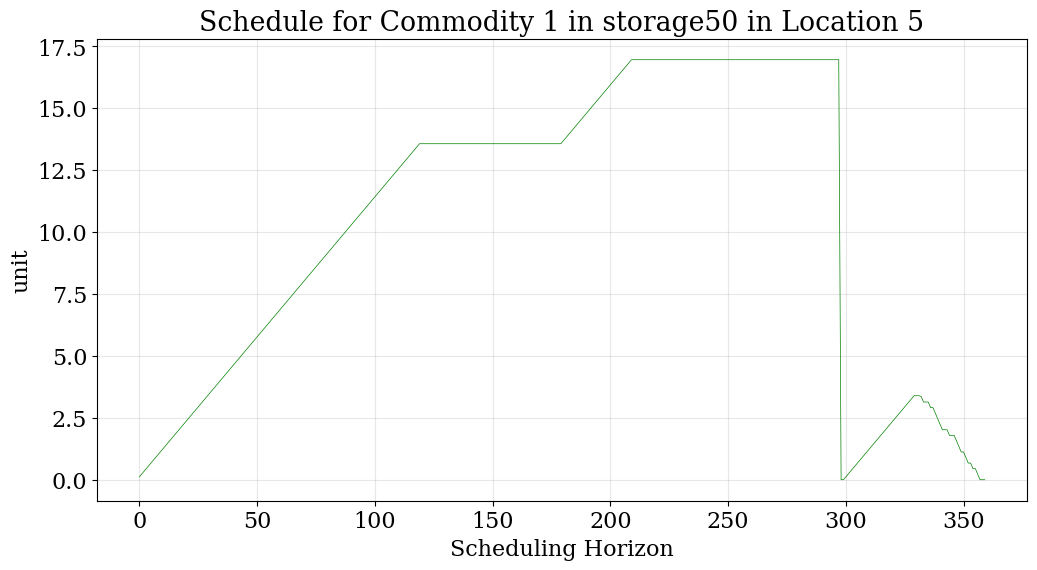

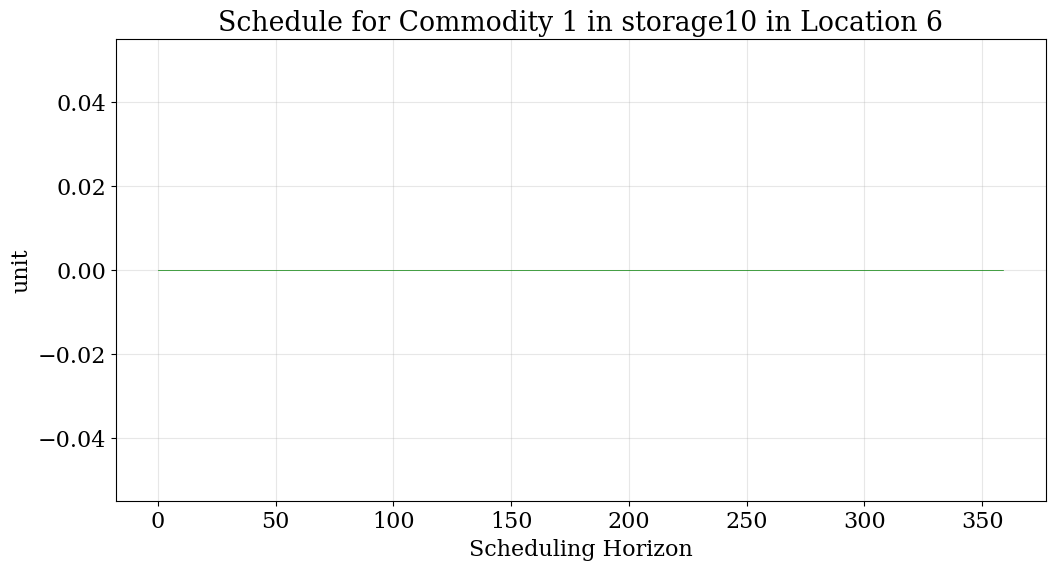

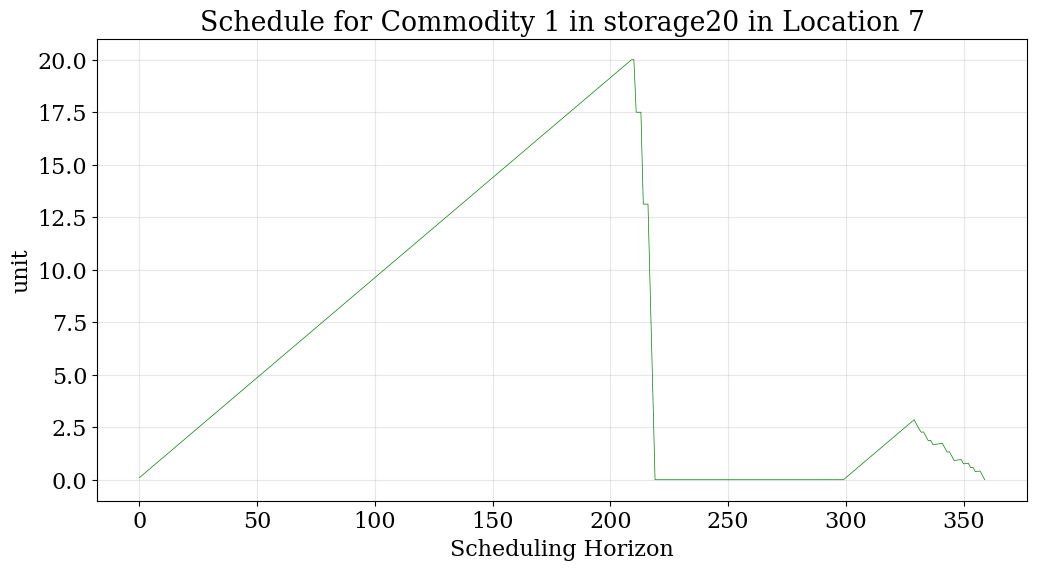

In [21]:
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored20', location='loc1', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored20', location='loc2', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored20', location='loc3', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored50', location='loc4', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored50', location='loc5', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored10', location='loc6', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored20', location='loc7', color='green')

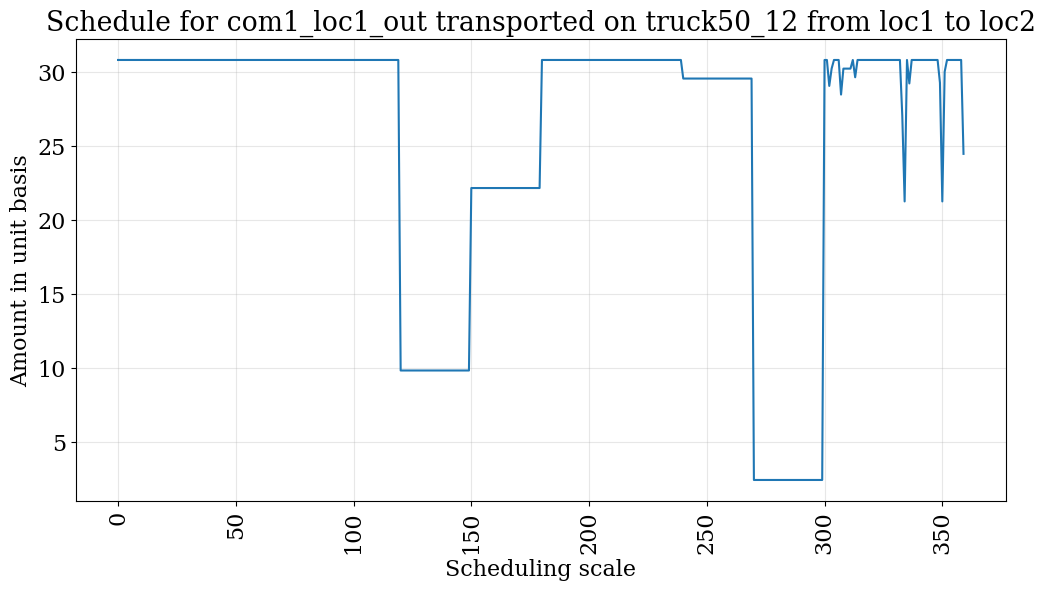

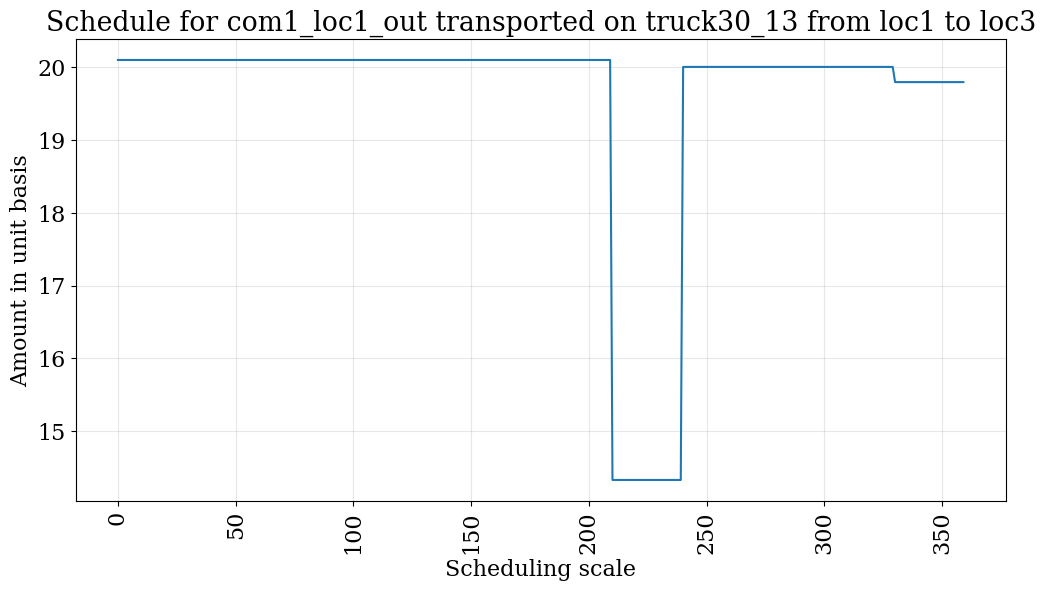

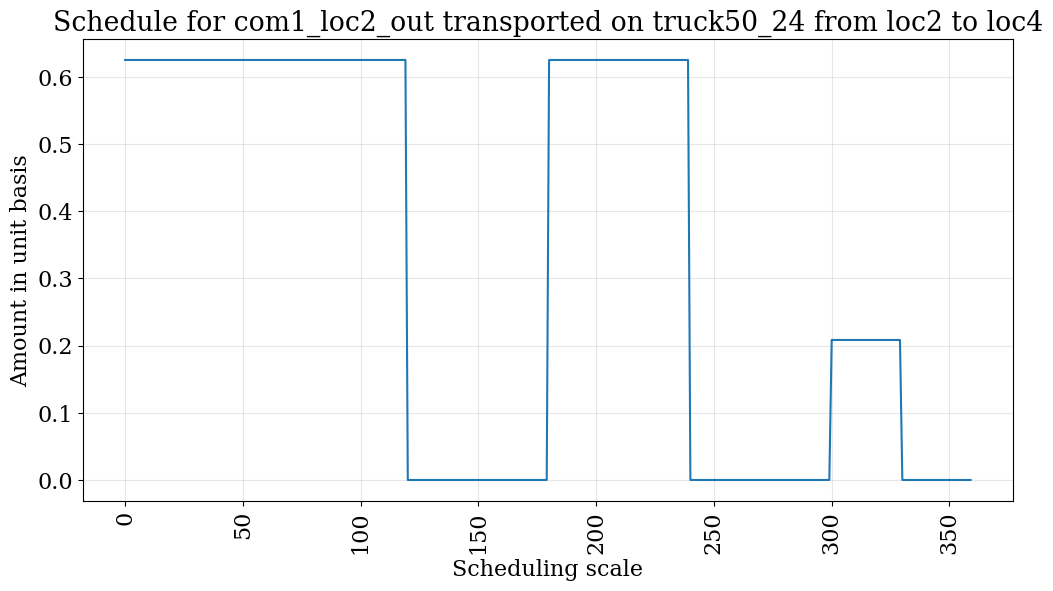

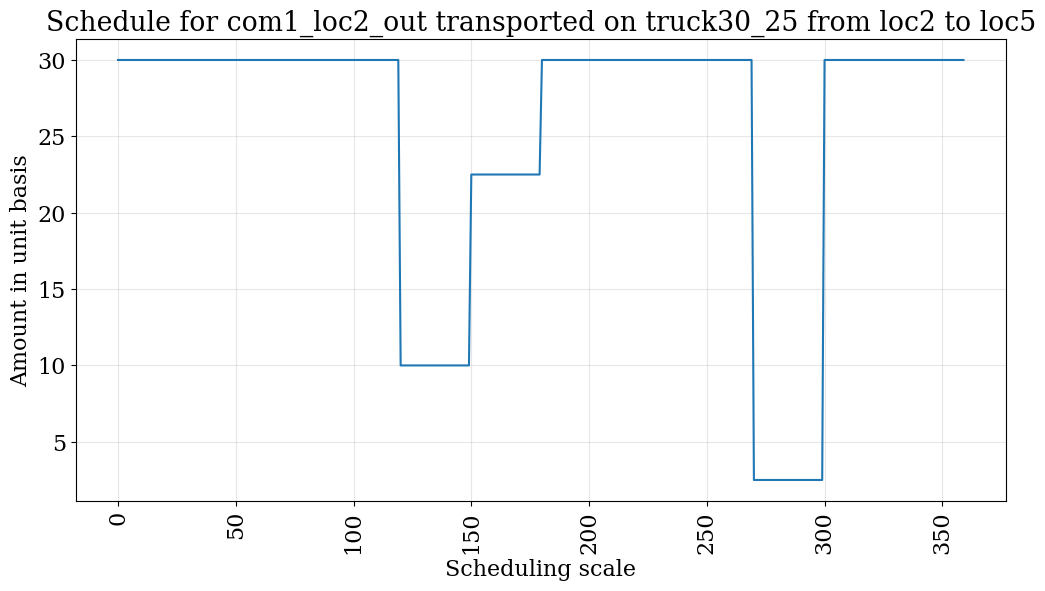

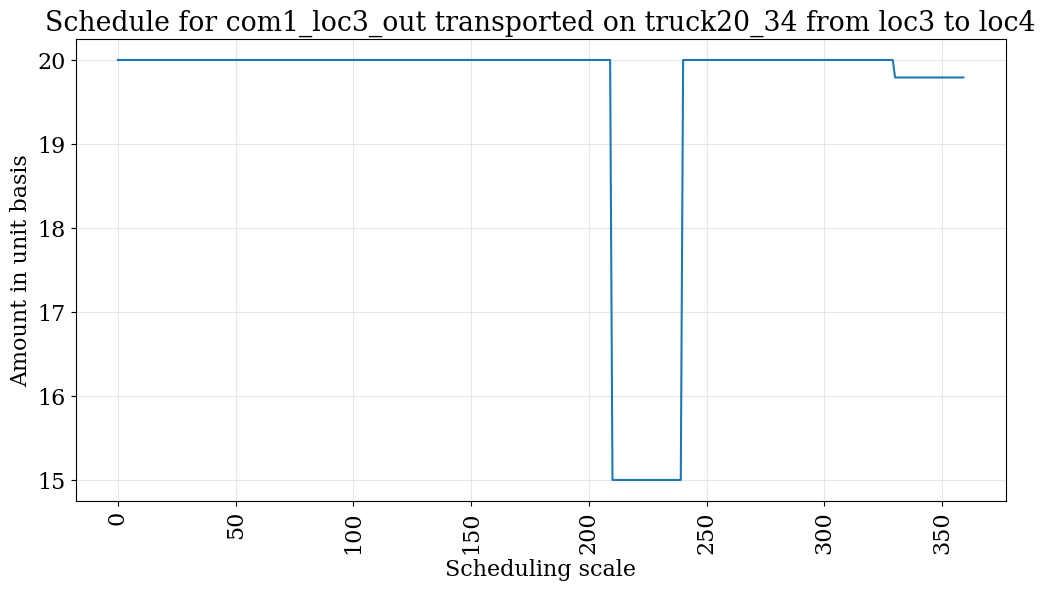

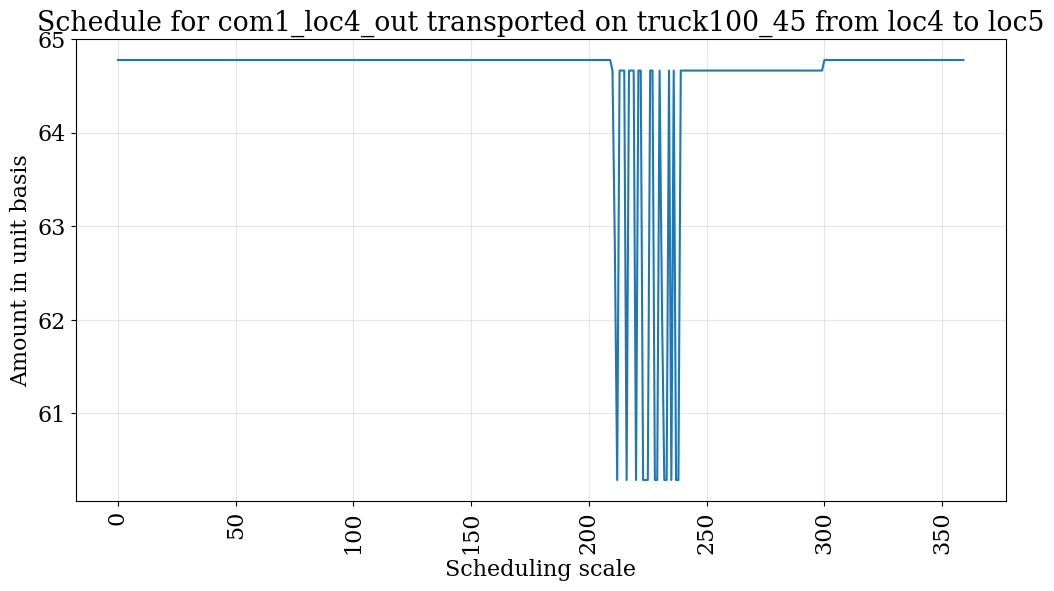

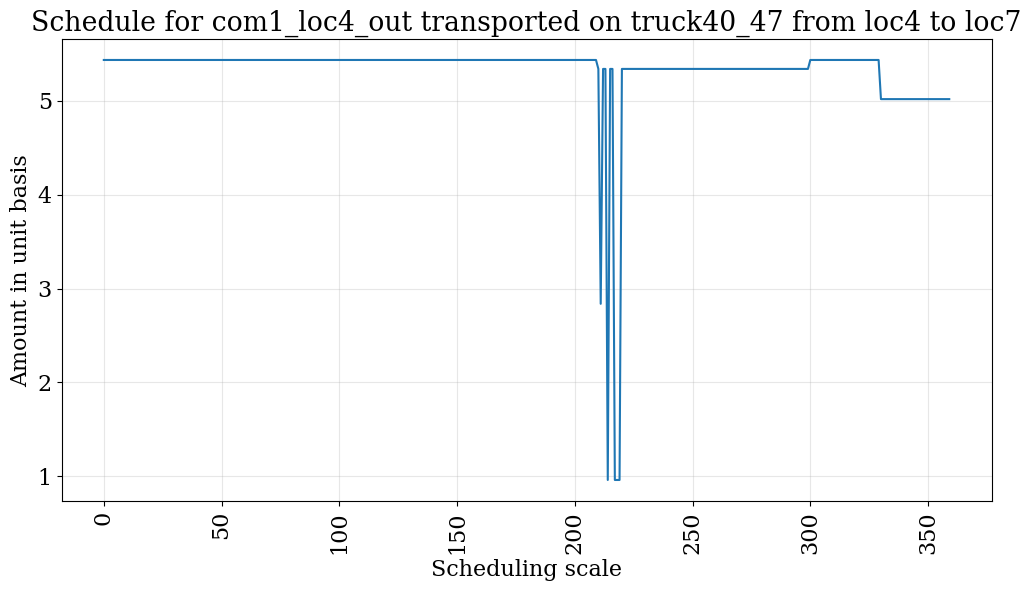

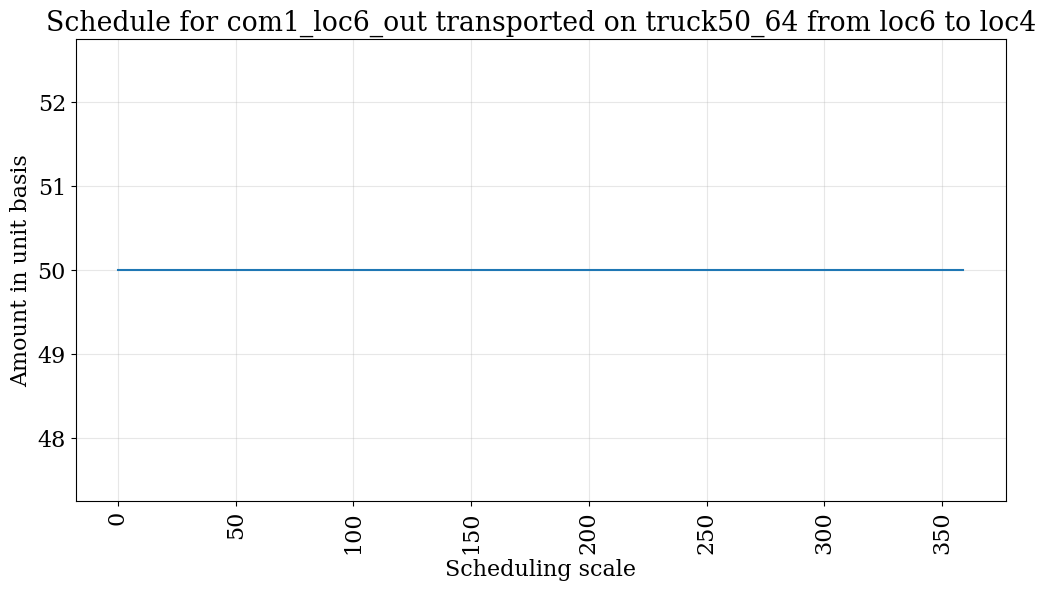

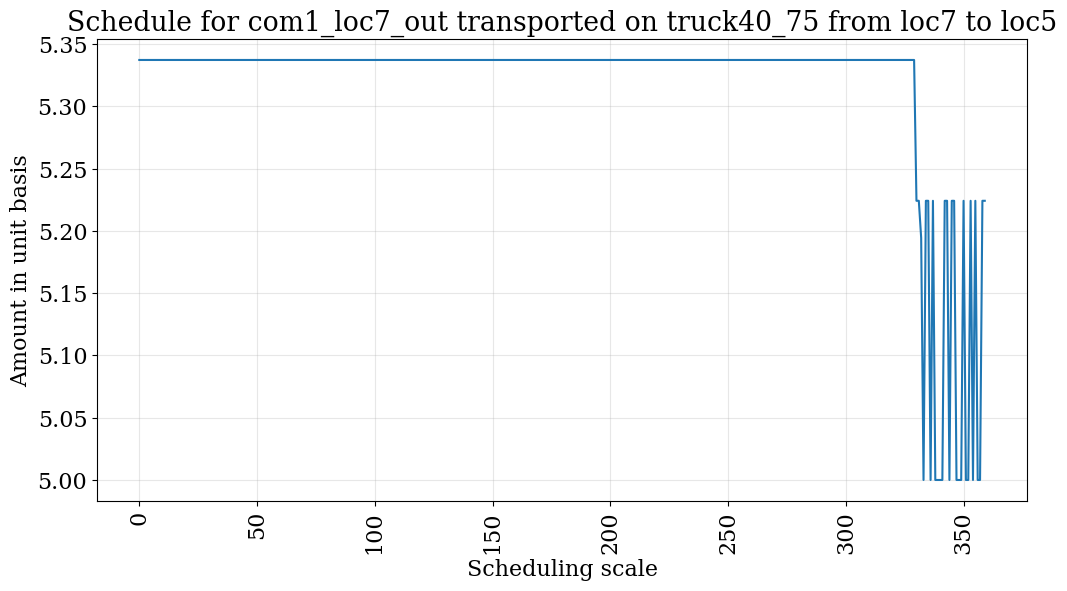

In [22]:
plot_results.transport(results=results_mincost, source='loc1', sink='loc2', transport='truck50_12',
                       resource='com1_loc1_out')
plot_results.transport(results=results_mincost, source='loc1', sink='loc3', transport='truck30_13',
                       resource='com1_loc1_out')
plot_results.transport(results=results_mincost, source='loc2', sink='loc4', transport='truck50_24',
                       resource='com1_loc2_out')
plot_results.transport(results=results_mincost, source='loc2', sink='loc5', transport='truck30_25',
                       resource='com1_loc2_out')
plot_results.transport(results=results_mincost, source='loc3', sink='loc4', transport='truck20_34',
                       resource='com1_loc3_out')
plot_results.transport(results=results_mincost, source='loc4', sink='loc5', transport='truck100_45',
                       resource='com1_loc4_out')
plot_results.transport(results=results_mincost, source='loc4', sink='loc7', transport='truck40_47',
                       resource='com1_loc4_out')
plot_results.transport(results=results_mincost, source='loc6', sink='loc4', transport='truck50_64',
                       resource='com1_loc6_out')
plot_results.transport(results=results_mincost, source='loc7', sink='loc5', transport='truck40_75',
                       resource='com1_loc7_out')

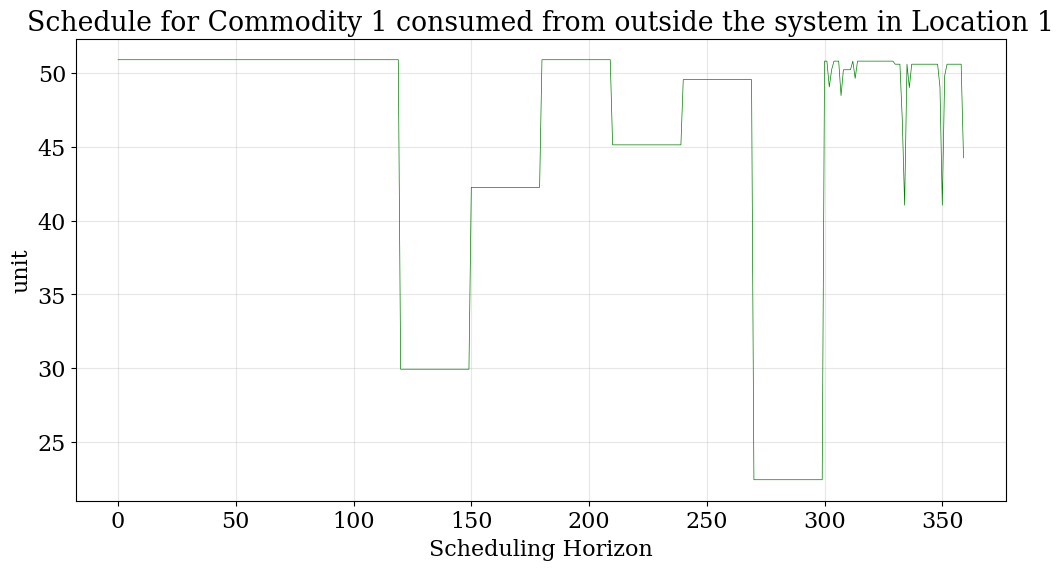

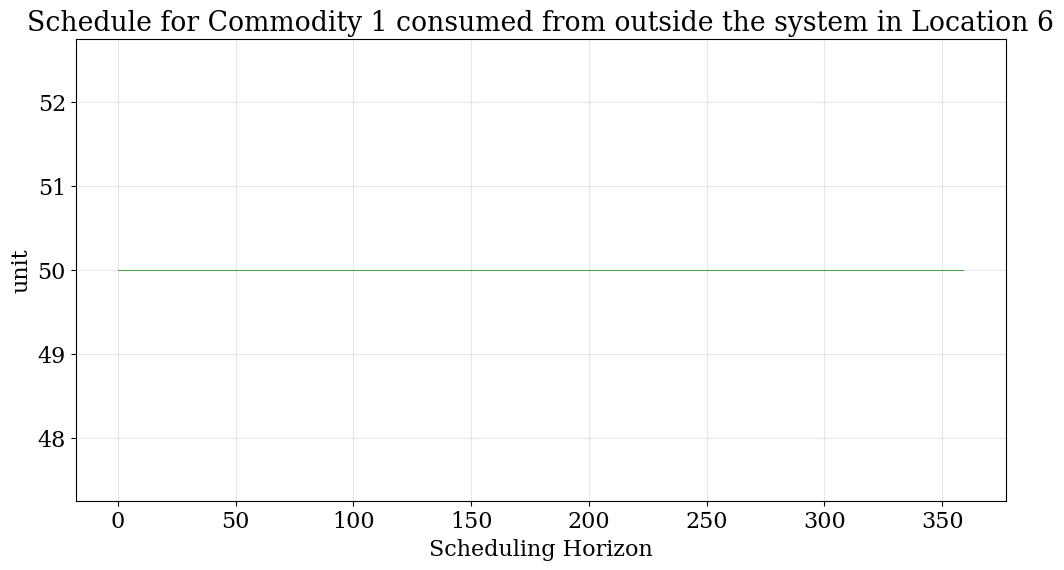

In [23]:
plot_results.schedule(results=results_mincost, y_axis='C', component='com1_pur', location='loc1', color='green')
plot_results.schedule(results=results_mincost, y_axis='C', component='com1_pur', location='loc6', color='green')

In [24]:
list(scenario_disruption.capacity_factor['loc2']['com1_process'].values())

[1.0, 1.0, 1.0, 0.19, 0.04, 0.09, 0.13, 0.19, 0.12, 0.01, 0.13, 0.17]

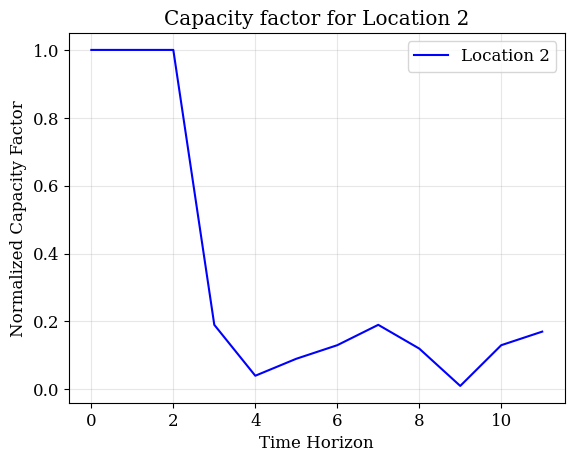

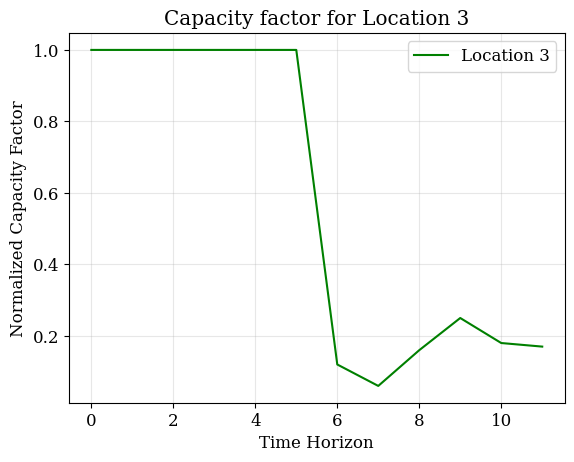

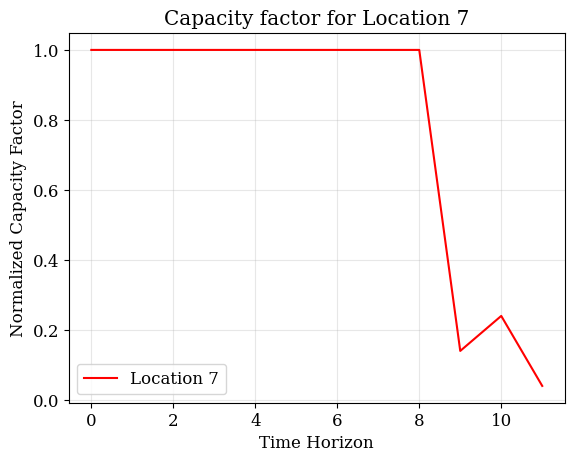

In [25]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(scenario_disruption.capacity_factor['loc2']['com1_process'].values()))), list(scenario_disruption.capacity_factor['loc2']['com1_process'].values()), label='Location 2',
        color='blue')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Normalized Capacity Factor')
ax.set_title('Capacity factor for Location 2')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(scenario_disruption.capacity_factor['loc3']['com1_process'].values()))), list(scenario_disruption.capacity_factor['loc3']['com1_process'].values()), label='Location 3',
        color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Normalized Capacity Factor')
ax.set_title('Capacity factor for Location 3')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(scenario_disruption.capacity_factor['loc7']['com1_process'].values()))), list(scenario_disruption.capacity_factor['loc7']['com1_process'].values()), label='Location 7',
        color='red')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Normalized Capacity Factor')
ax.set_title('Capacity factor for Location 7')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

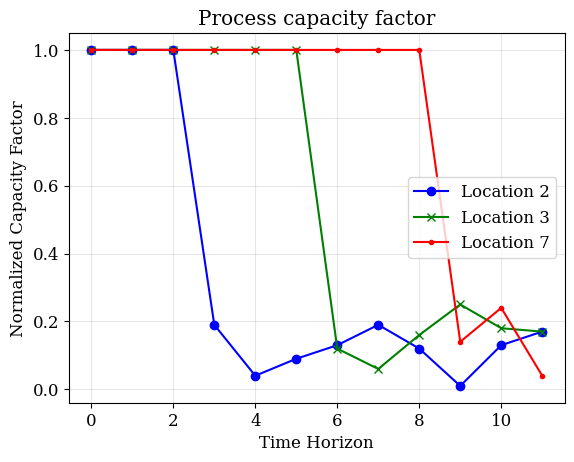

In [26]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(scenario_disruption.capacity_factor['loc2']['com1_process'].values()))), list(scenario_disruption.capacity_factor['loc2']['com1_process'].values()), label='Location 2',
        color='blue', marker='o')

ax.plot(range(len(list(scenario_disruption.capacity_factor['loc3']['com1_process'].values()))), list(scenario_disruption.capacity_factor['loc3']['com1_process'].values()), label='Location 3',
        color='green', marker='x')

ax.plot(range(len(list(scenario_disruption.capacity_factor['loc7']['com1_process'].values()))), list(scenario_disruption.capacity_factor['loc7']['com1_process'].values()), label='Location 7',
        color='red', marker='.')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Normalized Capacity Factor')
ax.set_title('Process capacity factor')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

In [27]:
problem_mincost_2 = formulate(scenario=scenario_disruption,
                              constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
                                           Constraints.PRODUCTION, Constraints.INVENTORY, Constraints.DEMAND},
                              demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

min_demand_satisfaction_2 = 0.75
min_demand_dict_2 = {i: {com1_sold: min_demand_satisfaction_2 * 100} if i == loc5 else {com1_sold: 0} for i in locset}

min_demand_2 = min_demand_dict_2
if isinstance(min_demand_2, dict):
    if isinstance(list(min_demand_2.keys())[0], Location):
        try:
            min_demand_2 = {i.name: {
                j.name: min_demand_2[i][j] for j in min_demand_2[i].keys()} for i in min_demand_2.keys()}
        except:
            pass

problem_mincost_2.del_component(constraint_demand2)
problem_mincost_2.constraint_demand2 = constraint_demand2(instance=problem_mincost_2, demand=min_demand_2,
                                                          demand_factor=scenario_disruption.demand_factor,
                                                          demand_scale_level=scenario_disruption.demand_scale_level,
                                                          scheduling_scale_level=scenario_disruption.scheduling_scale_level,
                                                          cluster_wt=None, loc_res_dict=None, sign='geq')

results_mincost_2 = solve(scenario=scenario_disruption, instance=problem_mincost_2, solver='gurobi', name='MILP')

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint production mode
constraint inventory balance
constraint resource export
constraint transport export
constraint export
constraint transport capacity UB
constraint transport capacity LB
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint demand penalty
objective cost w demand penalty
constraint demand2
Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 427877 rows, 1346807 columns and 689196 nonzeros
Model fingerprint: 0x233e225c
Variable types: 1346366 continuous, 441 integer (441 binary)
Coefficient statistics:
  Matrix range    

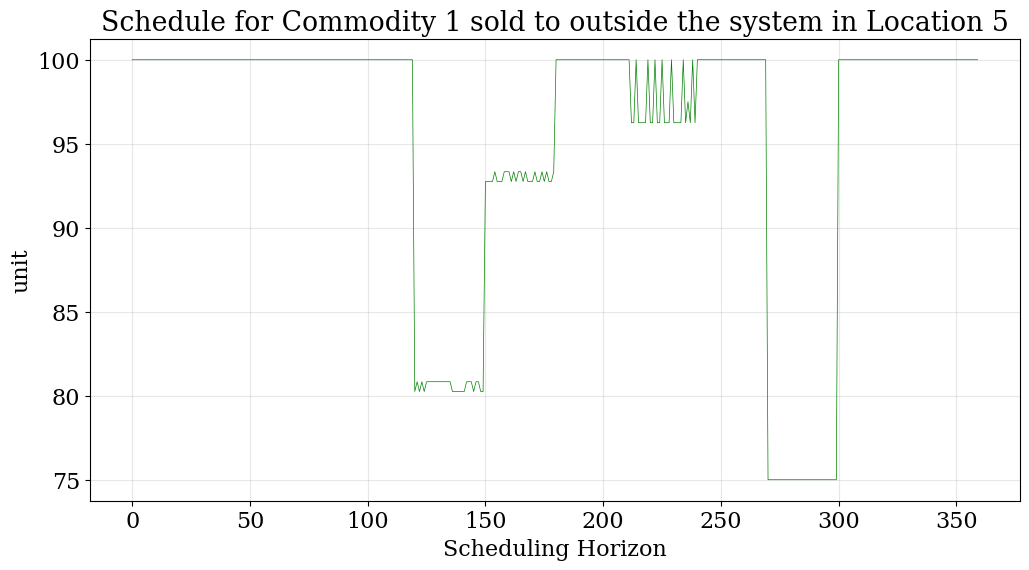

In [28]:
plot_results.schedule(results=results_mincost_2, y_axis='S', component='com1_sold', location='loc5', color='green')

In [29]:
min(value for key, value in results_mincost_2.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold')

75.0

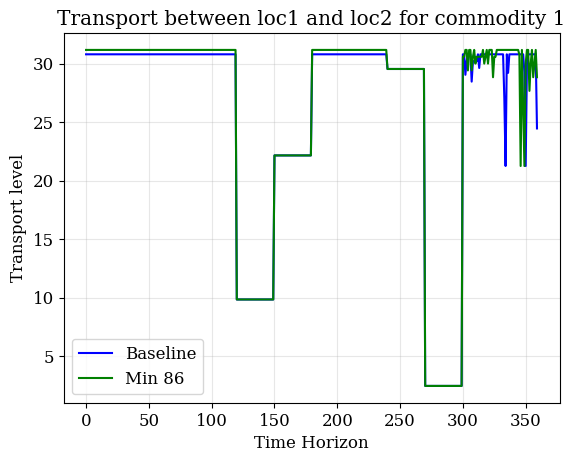

In [30]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if
                       key[0] == 'loc1' and key[1] == 'loc2' and key[2] == 'truck50_12' and key[
                           3] == 'com1_loc1_out'))), list(
    value for key, value in results_mincost.output['Exp'].items() if
    key[0] == 'loc1' and key[1] == 'loc2' and key[2] == 'truck50_12' and key[3] == 'com1_loc1_out'), label='Baseline',
        color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['Exp'].items() if
                       key[0] == 'loc1' and key[1] == 'loc2' and key[2] == 'truck50_12' and key[
                           3] == 'com1_loc1_out'))), list(
    value for key, value in results_mincost_2.output['Exp'].items() if
    key[0] == 'loc1' and key[1] == 'loc2' and key[2] == 'truck50_12' and key[3] == 'com1_loc1_out'), label='Min 86',
        color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc1 and loc2 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

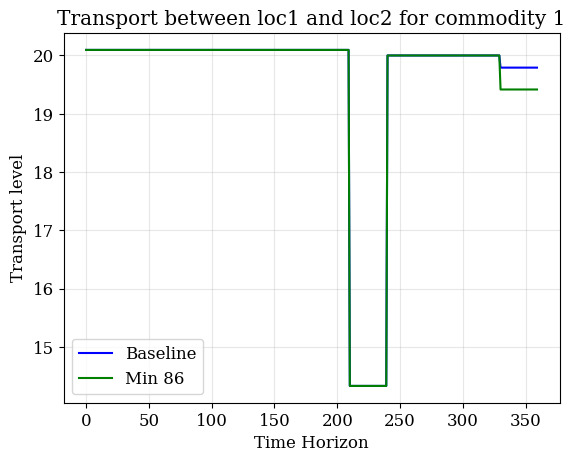

In [31]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if
                       key[0] == 'loc1' and key[1] == 'loc3' and key[2] == 'truck30_13' and key[
                           3] == 'com1_loc1_out'))), list(
    value for key, value in results_mincost.output['Exp'].items() if
    key[0] == 'loc1' and key[1] == 'loc3' and key[2] == 'truck30_13' and key[3] == 'com1_loc1_out'), label='Baseline',
        color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['Exp'].items() if
                       key[0] == 'loc1' and key[1] == 'loc3' and key[2] == 'truck30_13' and key[
                           3] == 'com1_loc1_out'))), list(
    value for key, value in results_mincost_2.output['Exp'].items() if
    key[0] == 'loc1' and key[1] == 'loc3' and key[2] == 'truck30_13' and key[3] == 'com1_loc1_out'), label='Min 86',
        color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc1 and loc2 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

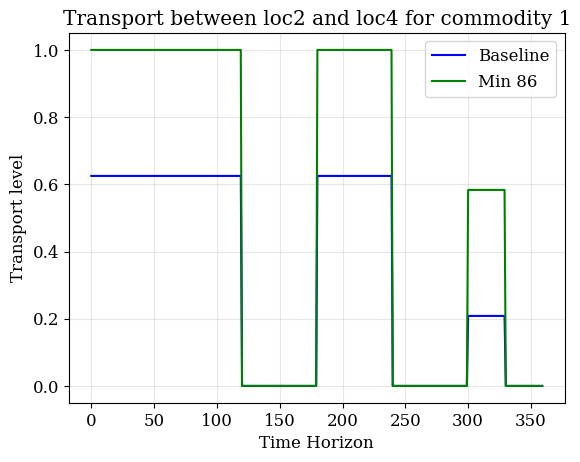

In [32]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if
                       key[0] == 'loc2' and key[1] == 'loc4' and key[2] == 'truck50_24' and key[
                           3] == 'com1_loc2_out'))), list(
    value for key, value in results_mincost.output['Exp'].items() if
    key[0] == 'loc2' and key[1] == 'loc4' and key[2] == 'truck50_24' and key[3] == 'com1_loc2_out'), label='Baseline',
        color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['Exp'].items() if
                       key[0] == 'loc2' and key[1] == 'loc4' and key[2] == 'truck50_24' and key[
                           3] == 'com1_loc2_out'))), list(
    value for key, value in results_mincost_2.output['Exp'].items() if
    key[0] == 'loc2' and key[1] == 'loc4' and key[2] == 'truck50_24' and key[3] == 'com1_loc2_out'), label='Min 86',
        color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc2 and loc4 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

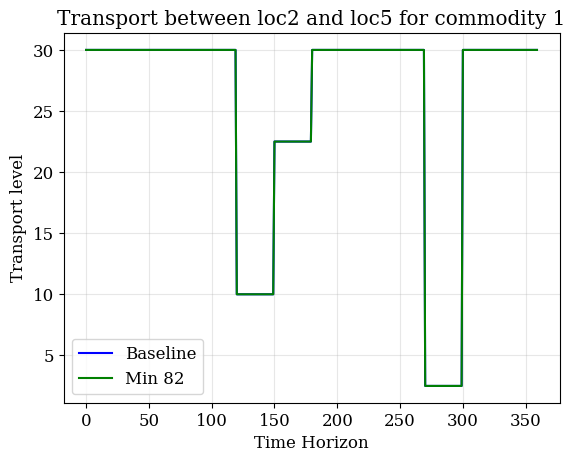

In [33]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if
                       key[0] == 'loc2' and key[1] == 'loc5' and key[2] == 'truck30_25' and key[
                           3] == 'com1_loc2_out'))), list(
    value for key, value in results_mincost.output['Exp'].items() if
    key[0] == 'loc2' and key[1] == 'loc5' and key[2] == 'truck30_25' and key[3] == 'com1_loc2_out'), label='Baseline',
        color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['Exp'].items() if
                       key[0] == 'loc2' and key[1] == 'loc5' and key[2] == 'truck30_25' and key[
                           3] == 'com1_loc2_out'))), list(
    value for key, value in results_mincost_2.output['Exp'].items() if
    key[0] == 'loc2' and key[1] == 'loc5' and key[2] == 'truck30_25' and key[3] == 'com1_loc2_out'), label='Min 82',
        color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc2 and loc5 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

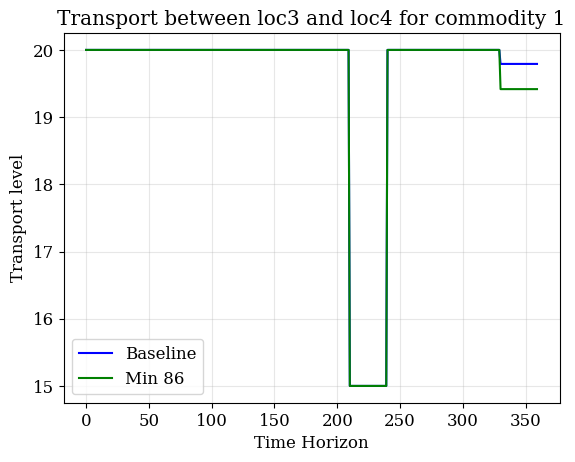

In [34]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if
                       key[0] == 'loc3' and key[1] == 'loc4' and key[2] == 'truck20_34' and key[
                           3] == 'com1_loc3_out'))), list(
    value for key, value in results_mincost.output['Exp'].items() if
    key[0] == 'loc3' and key[1] == 'loc4' and key[2] == 'truck20_34' and key[3] == 'com1_loc3_out'), label='Baseline',
        color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['Exp'].items() if
                       key[0] == 'loc3' and key[1] == 'loc4' and key[2] == 'truck20_34' and key[
                           3] == 'com1_loc3_out'))), list(
    value for key, value in results_mincost_2.output['Exp'].items() if
    key[0] == 'loc3' and key[1] == 'loc4' and key[2] == 'truck20_34' and key[3] == 'com1_loc3_out'), label='Min 86',
        color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc3 and loc4 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

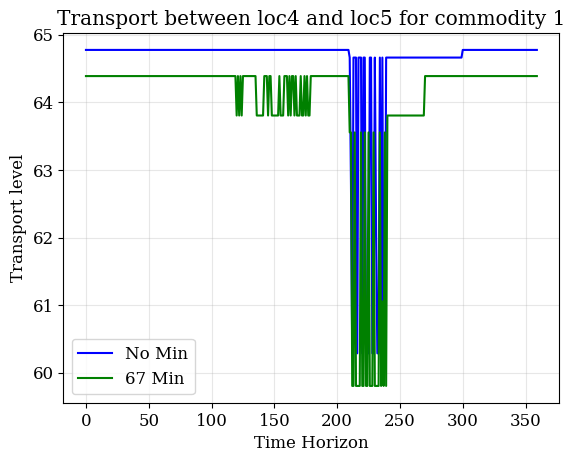

In [35]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if
                       key[0] == 'loc4' and key[1] == 'loc5' and key[2] == 'truck100_45' and key[
                           3] == 'com1_loc4_out'))), list(
    value for key, value in results_mincost.output['Exp'].items() if
    key[0] == 'loc4' and key[1] == 'loc5' and key[2] == 'truck100_45' and key[3] == 'com1_loc4_out'), label='No Min',
        color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['Exp'].items() if
                       key[0] == 'loc4' and key[1] == 'loc5' and key[2] == 'truck100_45' and key[
                           3] == 'com1_loc4_out'))), list(
    value for key, value in results_mincost_2.output['Exp'].items() if
    key[0] == 'loc4' and key[1] == 'loc5' and key[2] == 'truck100_45' and key[3] == 'com1_loc4_out'), label='67 Min',
        color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc4 and loc5 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

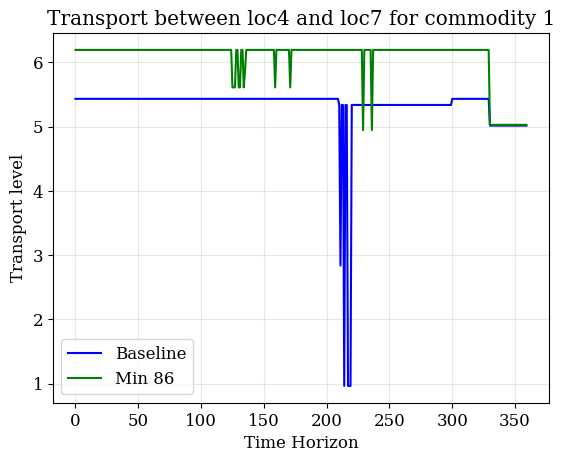

In [36]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if
                       key[0] == 'loc4' and key[1] == 'loc7' and key[2] == 'truck40_47' and key[
                           3] == 'com1_loc4_out'))), list(
    value for key, value in results_mincost.output['Exp'].items() if
    key[0] == 'loc4' and key[1] == 'loc7' and key[2] == 'truck40_47' and key[3] == 'com1_loc4_out'), label='Baseline',
        color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['Exp'].items() if
                       key[0] == 'loc4' and key[1] == 'loc7' and key[2] == 'truck40_47' and key[
                           3] == 'com1_loc4_out'))), list(
    value for key, value in results_mincost_2.output['Exp'].items() if
    key[0] == 'loc4' and key[1] == 'loc7' and key[2] == 'truck40_47' and key[3] == 'com1_loc4_out'), label='Min 86',
        color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc4 and loc7 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

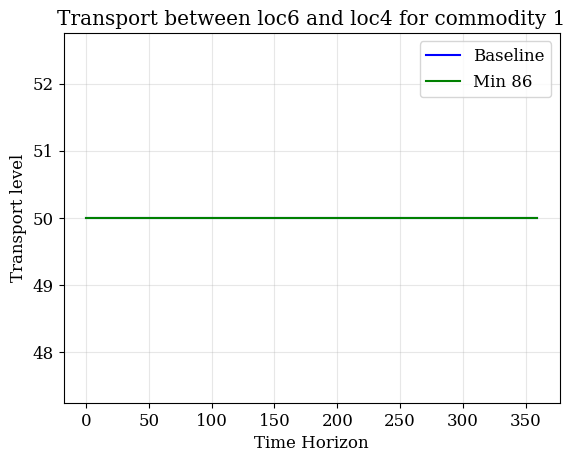

In [37]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if
                       key[0] == 'loc6' and key[1] == 'loc4' and key[2] == 'truck50_64' and key[
                           3] == 'com1_loc6_out'))), list(
    value for key, value in results_mincost.output['Exp'].items() if
    key[0] == 'loc6' and key[1] == 'loc4' and key[2] == 'truck50_64' and key[3] == 'com1_loc6_out'), label='Baseline',
        color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['Exp'].items() if
                       key[0] == 'loc6' and key[1] == 'loc4' and key[2] == 'truck50_64' and key[
                           3] == 'com1_loc6_out'))), list(
    value for key, value in results_mincost_2.output['Exp'].items() if
    key[0] == 'loc6' and key[1] == 'loc4' and key[2] == 'truck50_64' and key[3] == 'com1_loc6_out'), label='Min 86',
        color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc6 and loc4 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

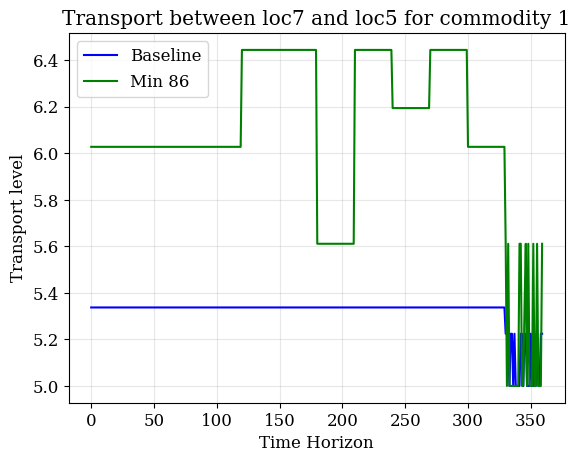

In [38]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if
                       key[0] == 'loc7' and key[1] == 'loc5' and key[2] == 'truck40_75' and key[
                           3] == 'com1_loc7_out'))), list(
    value for key, value in results_mincost.output['Exp'].items() if
    key[0] == 'loc7' and key[1] == 'loc5' and key[2] == 'truck40_75' and key[3] == 'com1_loc7_out'), label='Baseline',
        color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['Exp'].items() if
                       key[0] == 'loc7' and key[1] == 'loc5' and key[2] == 'truck40_75' and key[
                           3] == 'com1_loc7_out'))), list(
    value for key, value in results_mincost_2.output['Exp'].items() if
    key[0] == 'loc7' and key[1] == 'loc5' and key[2] == 'truck40_75' and key[3] == 'com1_loc7_out'), label='Min 86',
        color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc7 and loc5 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

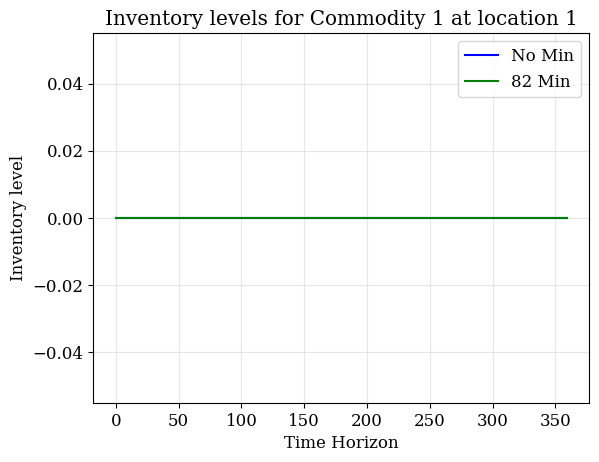

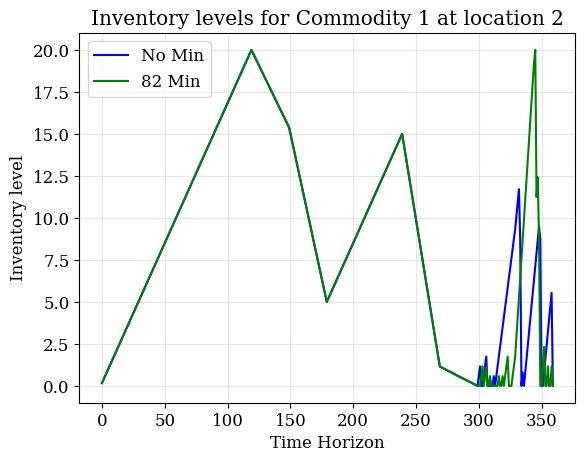

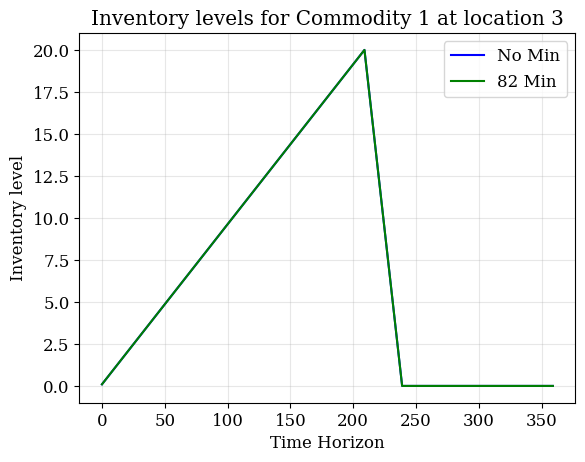

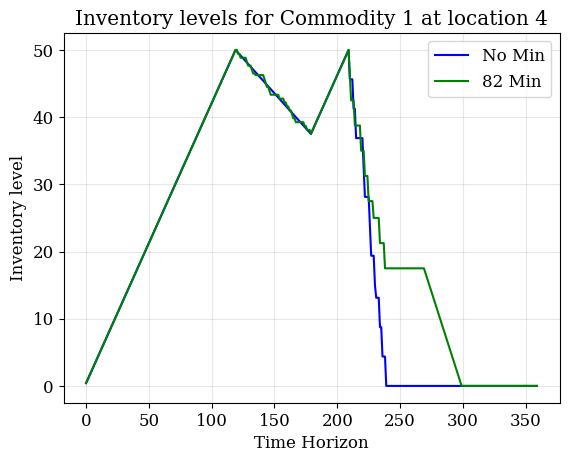

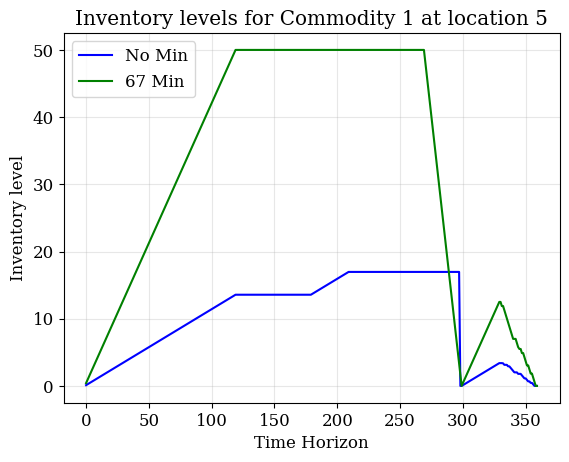

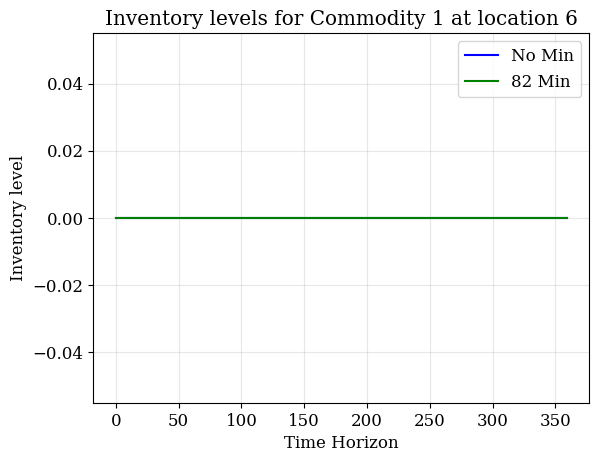

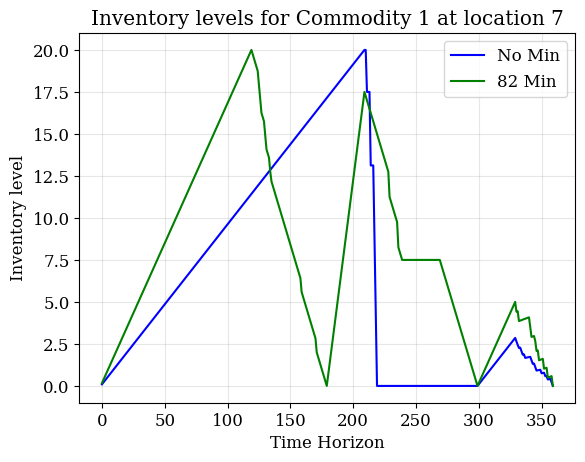

In [39]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(
    value for key, value in results_mincost.output['Inv'].items() if key[0] == 'loc1' and key[1] == 'com1_stored20'))),
        list(value for key, value in results_mincost.output['Inv'].items() if
             key[0] == 'loc1' and key[1] == 'com1_stored20'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['Inv'].items() if
                       key[0] == 'loc1' and key[1] == 'com1_stored20'))), list(
    value for key, value in results_mincost_2.output['Inv'].items() if key[0] == 'loc1' and key[1] == 'com1_stored20'),
        label='82 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(
    value for key, value in results_mincost.output['Inv'].items() if key[0] == 'loc2' and key[1] == 'com1_stored20'))),
        list(value for key, value in results_mincost.output['Inv'].items() if
             key[0] == 'loc2' and key[1] == 'com1_stored20'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['Inv'].items() if
                       key[0] == 'loc2' and key[1] == 'com1_stored20'))), list(
    value for key, value in results_mincost_2.output['Inv'].items() if key[0] == 'loc2' and key[1] == 'com1_stored20'),
        label='82 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 2')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(
    value for key, value in results_mincost.output['Inv'].items() if key[0] == 'loc3' and key[1] == 'com1_stored20'))),
        list(value for key, value in results_mincost.output['Inv'].items() if
             key[0] == 'loc3' and key[1] == 'com1_stored20'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['Inv'].items() if
                       key[0] == 'loc3' and key[1] == 'com1_stored20'))), list(
    value for key, value in results_mincost_2.output['Inv'].items() if key[0] == 'loc3' and key[1] == 'com1_stored20'),
        label='82 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 3')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(
    value for key, value in results_mincost.output['Inv'].items() if key[0] == 'loc4' and key[1] == 'com1_stored50'))),
        list(value for key, value in results_mincost.output['Inv'].items() if
             key[0] == 'loc4' and key[1] == 'com1_stored50'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['Inv'].items() if
                       key[0] == 'loc4' and key[1] == 'com1_stored50'))), list(
    value for key, value in results_mincost_2.output['Inv'].items() if key[0] == 'loc4' and key[1] == 'com1_stored50'),
        label='82 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 4')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(
    value for key, value in results_mincost.output['Inv'].items() if key[0] == 'loc5' and key[1] == 'com1_stored50'))),
        list(value for key, value in results_mincost.output['Inv'].items() if
             key[0] == 'loc5' and key[1] == 'com1_stored50'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['Inv'].items() if
                       key[0] == 'loc5' and key[1] == 'com1_stored50'))), list(
    value for key, value in results_mincost_2.output['Inv'].items() if key[0] == 'loc5' and key[1] == 'com1_stored50'),
        label='67 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 5')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(
    value for key, value in results_mincost.output['Inv'].items() if key[0] == 'loc6' and key[1] == 'com1_stored10'))),
        list(value for key, value in results_mincost.output['Inv'].items() if
             key[0] == 'loc6' and key[1] == 'com1_stored10'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['Inv'].items() if
                       key[0] == 'loc6' and key[1] == 'com1_stored10'))), list(
    value for key, value in results_mincost_2.output['Inv'].items() if key[0] == 'loc6' and key[1] == 'com1_stored10'),
        label='82 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 6')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(
    value for key, value in results_mincost.output['Inv'].items() if key[0] == 'loc7' and key[1] == 'com1_stored20'))),
        list(value for key, value in results_mincost.output['Inv'].items() if
             key[0] == 'loc7' and key[1] == 'com1_stored20'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['Inv'].items() if
                       key[0] == 'loc7' and key[1] == 'com1_stored20'))), list(
    value for key, value in results_mincost_2.output['Inv'].items() if key[0] == 'loc7' and key[1] == 'com1_stored20'),
        label='82 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 7')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

In [42]:
problem_mincost_3 = formulate(scenario=scenario_disruption,
                              constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
                                           Constraints.PRODUCTION, Constraints.INVENTORY, Constraints.DEMAND},
                              demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

min_demand_satisfaction_3 = 0.76
min_demand_dict_3 = {i: {com1_sold: min_demand_satisfaction_3 * 100} if i == loc5 else {com1_sold: 0} for i in locset}

min_demand_3 = min_demand_dict_3
if isinstance(min_demand_3, dict):
    if isinstance(list(min_demand_3.keys())[0], Location):
        try:
            min_demand_3 = {i.name: {
                j.name: min_demand_3[i][j] for j in min_demand_3[i].keys()} for i in min_demand_3.keys()}
        except:
            pass

problem_mincost_3.del_component(constraint_demand2)
problem_mincost_3.constraint_demand2 = constraint_demand2(instance=problem_mincost_3, demand=min_demand_3,
                                                          demand_factor=scenario_disruption.demand_factor,
                                                          demand_scale_level=scenario_disruption.demand_scale_level,
                                                          scheduling_scale_level=scenario_disruption.scheduling_scale_level,
                                                          cluster_wt=None, loc_res_dict=None, sign='geq')

results_mincost_3 = solve(scenario=scenario_disruption, instance=problem_mincost_3, solver='gurobi', name='MILP')

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint production mode
constraint inventory balance
constraint resource export
constraint transport export
constraint export
constraint transport capacity UB
constraint transport capacity LB
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint demand penalty
objective cost w demand penalty
constraint demand2
Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 427877 rows, 1346807 columns and 689196 nonzeros
Model fingerprint: 0xea1d3aea
Variable types: 1346366 continuous, 441 integer (441 binary)
Coefficient statistics:
  Matrix range    

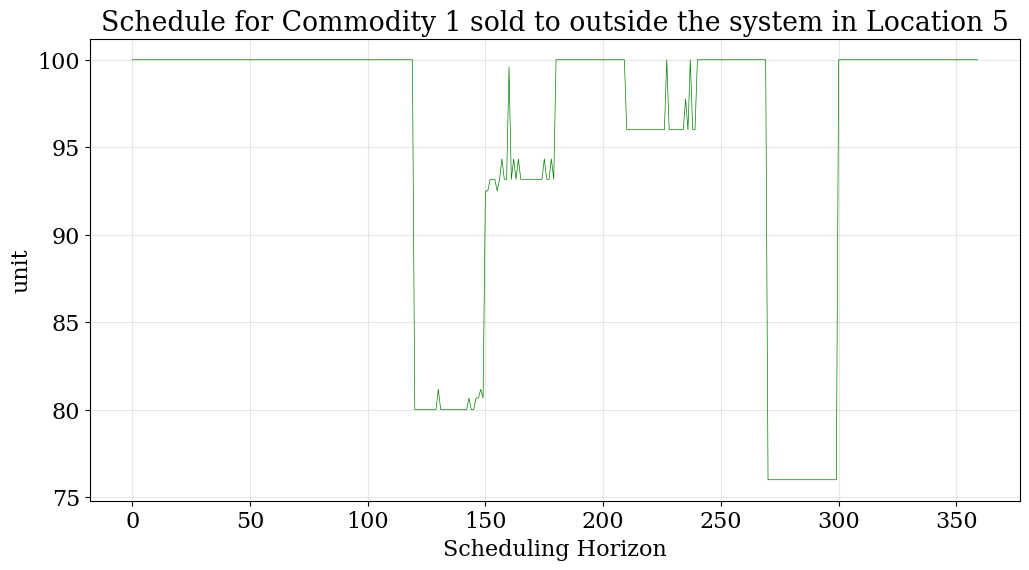

In [43]:
plot_results.schedule(results=results_mincost_3, y_axis='S', component='com1_sold', location='loc5', color='green')

In [44]:
min(value for key, value in results_mincost_3.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold')

76.0

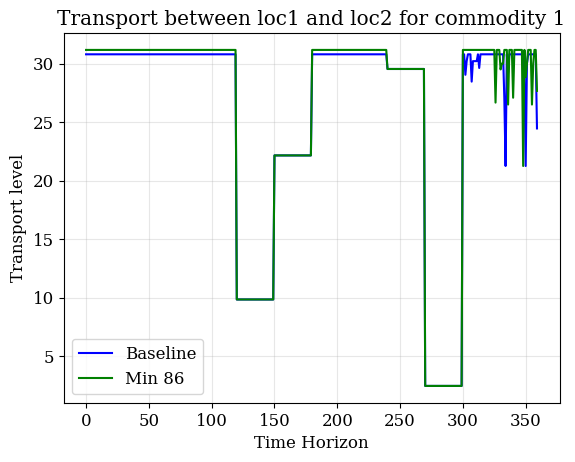

In [45]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc2'and key[2]=='truck50_12'and key[3]=='com1_loc1_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc2'and key[2]=='truck50_12'and key[3]=='com1_loc1_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc2'and key[2]=='truck50_12'and key[3]=='com1_loc1_out'))), list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc2'and key[2]=='truck50_12'and key[3]=='com1_loc1_out'), label='Min 86', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc1 and loc2 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

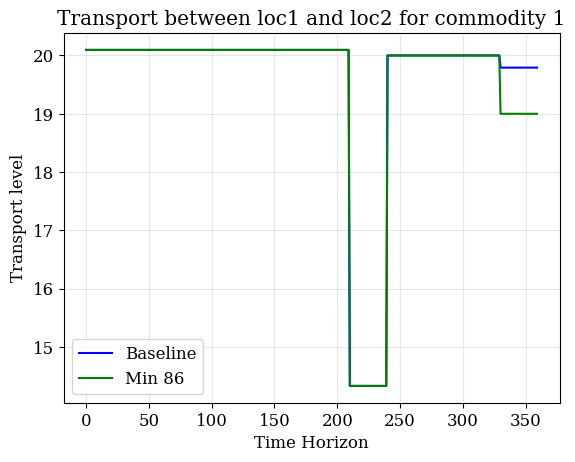

In [46]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc3'and key[2]=='truck30_13'and key[3]=='com1_loc1_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc3'and key[2]=='truck30_13'and key[3]=='com1_loc1_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc3'and key[2]=='truck30_13'and key[3]=='com1_loc1_out'))), list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc3'and key[2]=='truck30_13'and key[3]=='com1_loc1_out'), label='Min 86', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc1 and loc2 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

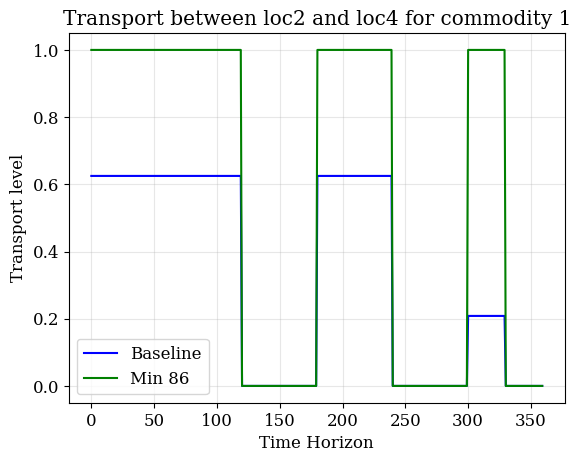

In [47]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc4'and key[2]=='truck50_24'and key[3]=='com1_loc2_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc4'and key[2]=='truck50_24'and key[3]=='com1_loc2_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc4'and key[2]=='truck50_24'and key[3]=='com1_loc2_out'))), list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc4'and key[2]=='truck50_24'and key[3]=='com1_loc2_out'), label='Min 86', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc2 and loc4 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

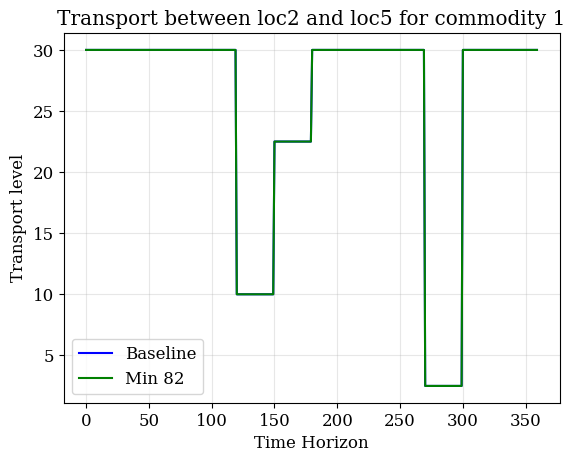

In [48]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc5'and key[2]=='truck30_25'and key[3]=='com1_loc2_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc5'and key[2]=='truck30_25'and key[3]=='com1_loc2_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc5'and key[2]=='truck30_25'and key[3]=='com1_loc2_out'))), list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc5'and key[2]=='truck30_25'and key[3]=='com1_loc2_out'), label='Min 82', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc2 and loc5 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

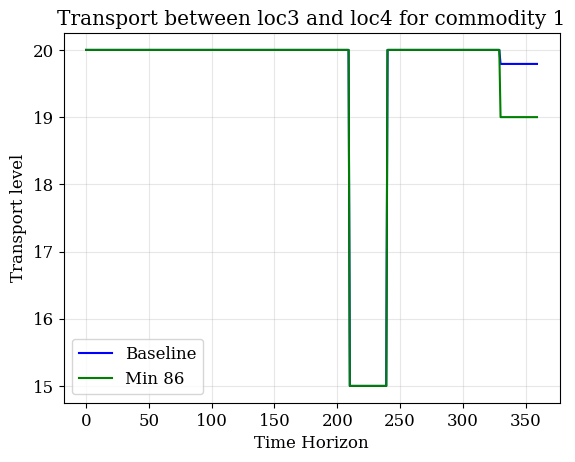

In [49]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc3' and key[1]=='loc4'and key[2]=='truck20_34'and key[3]=='com1_loc3_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc3' and key[1]=='loc4'and key[2]=='truck20_34'and key[3]=='com1_loc3_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc3' and key[1]=='loc4'and key[2]=='truck20_34'and key[3]=='com1_loc3_out'))), list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc3' and key[1]=='loc4'and key[2]=='truck20_34'and key[3]=='com1_loc3_out'), label='Min 86', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc3 and loc4 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

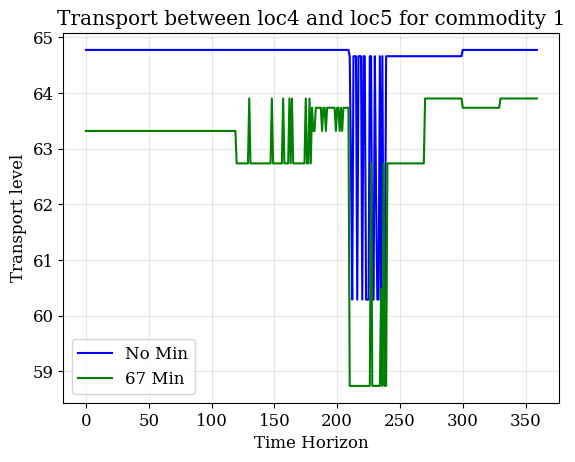

In [50]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc5'and key[2]=='truck100_45'and key[3]=='com1_loc4_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc5'and key[2]=='truck100_45'and key[3]=='com1_loc4_out'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc5'and key[2]=='truck100_45'and key[3]=='com1_loc4_out'))), list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc5'and key[2]=='truck100_45'and key[3]=='com1_loc4_out'), label='67 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc4 and loc5 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

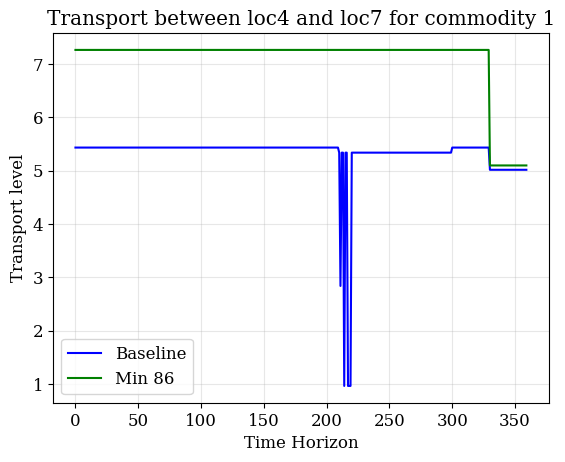

In [51]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc7'and key[2]=='truck40_47'and key[3]=='com1_loc4_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc7'and key[2]=='truck40_47'and key[3]=='com1_loc4_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc7'and key[2]=='truck40_47'and key[3]=='com1_loc4_out'))), list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc7'and key[2]=='truck40_47'and key[3]=='com1_loc4_out'), label='Min 86', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc4 and loc7 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

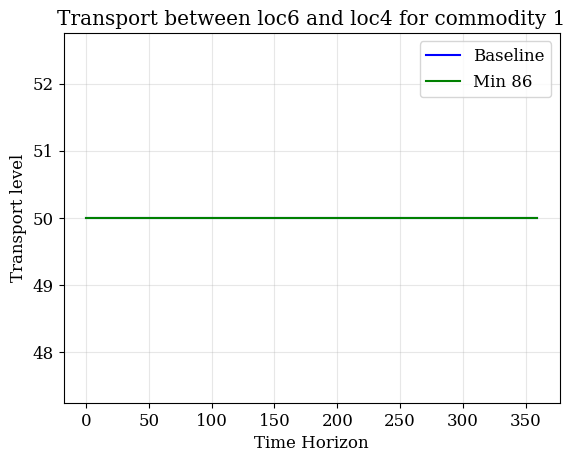

In [52]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc6' and key[1]=='loc4'and key[2]=='truck50_64'and key[3]=='com1_loc6_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc6' and key[1]=='loc4'and key[2]=='truck50_64'and key[3]=='com1_loc6_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc6' and key[1]=='loc4'and key[2]=='truck50_64'and key[3]=='com1_loc6_out'))), list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc6' and key[1]=='loc4'and key[2]=='truck50_64'and key[3]=='com1_loc6_out'), label='Min 86', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc6 and loc4 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

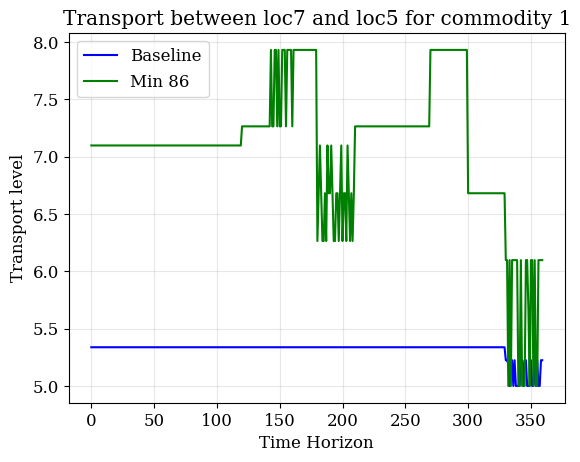

In [53]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc7' and key[1]=='loc5'and key[2]=='truck40_75'and key[3]=='com1_loc7_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc7' and key[1]=='loc5'and key[2]=='truck40_75'and key[3]=='com1_loc7_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc7' and key[1]=='loc5'and key[2]=='truck40_75'and key[3]=='com1_loc7_out'))), list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc7' and key[1]=='loc5'and key[2]=='truck40_75'and key[3]=='com1_loc7_out'), label='Min 86', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc7 and loc5 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

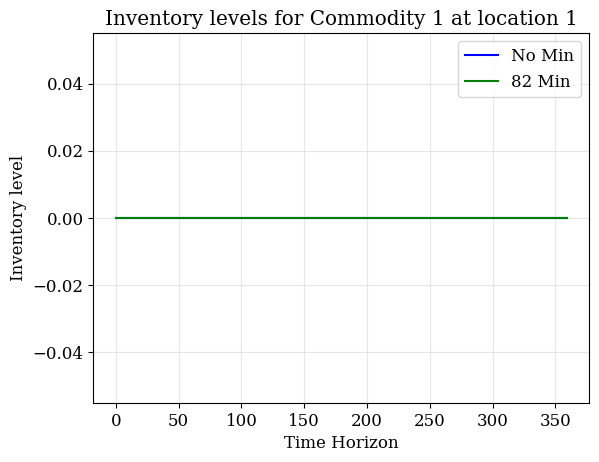

In [54]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc1' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc1' and key[1]=='com1_stored20'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_3.output['Inv'].items() if key[0]=='loc1' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost_3.output['Inv'].items() if key[0]=='loc1' and key[1]=='com1_stored20'), label='82 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

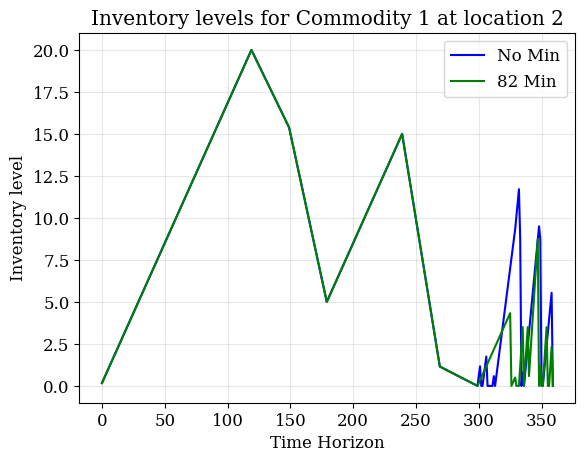

In [55]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc2' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc2' and key[1]=='com1_stored20'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_3.output['Inv'].items() if key[0]=='loc2' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost_3.output['Inv'].items() if key[0]=='loc2' and key[1]=='com1_stored20'), label='82 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 2')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

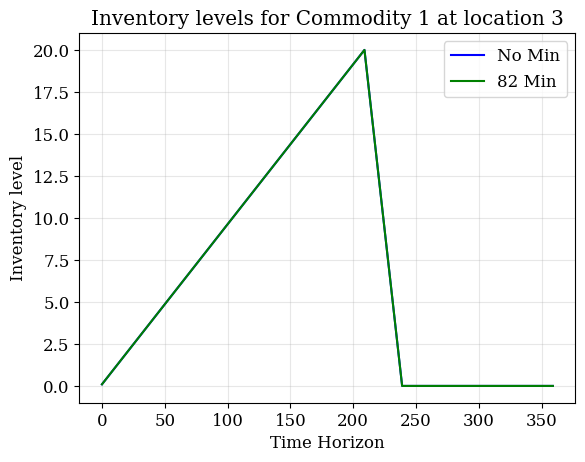

In [56]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc3' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc3' and key[1]=='com1_stored20'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_3.output['Inv'].items() if key[0]=='loc3' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost_3.output['Inv'].items() if key[0]=='loc3' and key[1]=='com1_stored20'), label='82 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 3')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

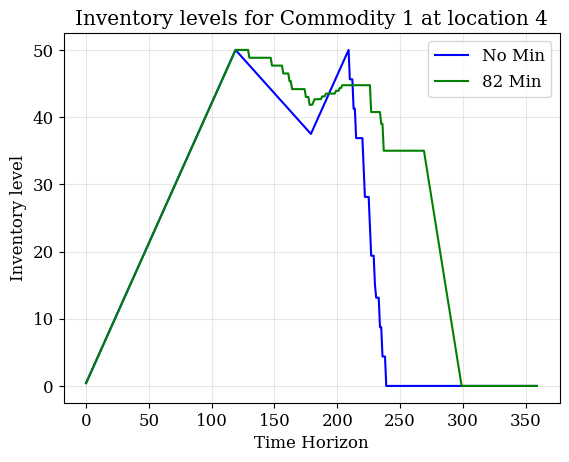

In [57]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc4' and key[1]=='com1_stored50'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc4' and key[1]=='com1_stored50'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_3.output['Inv'].items() if key[0]=='loc4' and key[1]=='com1_stored50'))), list(value for key, value in results_mincost_3.output['Inv'].items() if key[0]=='loc4' and key[1]=='com1_stored50'), label='82 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 4')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

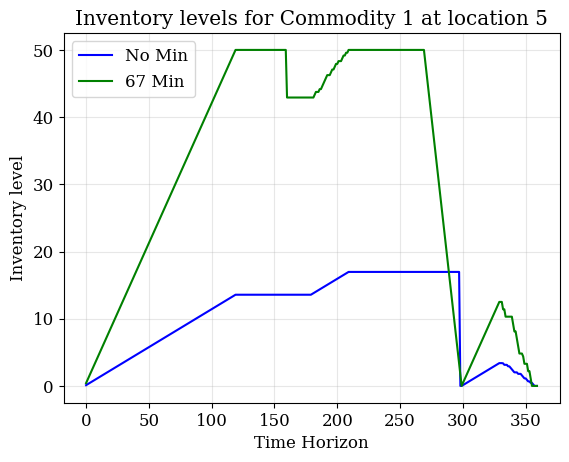

In [58]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc5' and key[1]=='com1_stored50'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc5' and key[1]=='com1_stored50'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_3.output['Inv'].items() if key[0]=='loc5' and key[1]=='com1_stored50'))), list(value for key, value in results_mincost_3.output['Inv'].items() if key[0]=='loc5' and key[1]=='com1_stored50'), label='67 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 5')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

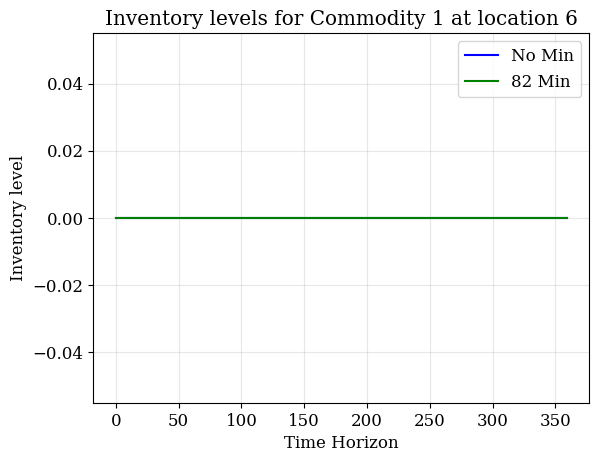

In [59]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_stored10'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_stored10'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_3.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_stored10'))), list(value for key, value in results_mincost_3.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_stored10'), label='82 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 6')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

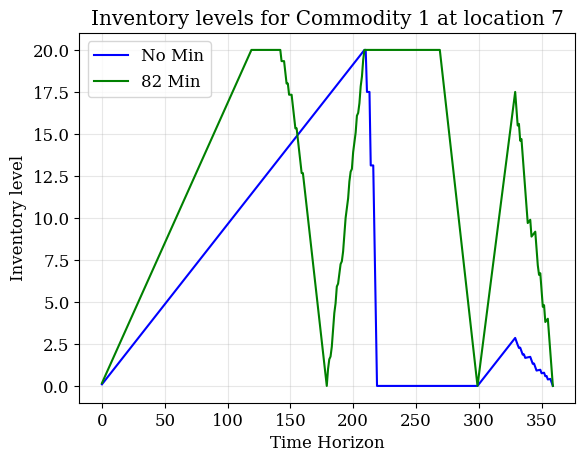

In [60]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_stored20'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_3.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost_3.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_stored20'), label='82 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 7')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

In [61]:
problem_mincost_3 = formulate(scenario=scenario_disruption,
                              constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
                                           Constraints.PRODUCTION, Constraints.INVENTORY, Constraints.DEMAND},
                              demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

min_demand_satisfaction_6 = 0.77
min_demand_dict_6 = {i: {com1_sold: min_demand_satisfaction_6 * 100} if i == loc5 else {com1_sold: 0} for i in locset}

min_demand_6 = min_demand_dict_6
if isinstance(min_demand_6, dict):
    if isinstance(list(min_demand_6.keys())[0], Location):
        try:
            min_demand_6 = {i.name: {
                j.name: min_demand_6[i][j] for j in min_demand_6[i].keys()} for i in min_demand_6.keys()}
        except:
            pass

problem_mincost_3.del_component(constraint_demand2)
problem_mincost_3.constraint_demand2 = constraint_demand2(instance=problem_mincost_3, demand=min_demand_6,
                                                          demand_factor=scenario_disruption.demand_factor,
                                                          demand_scale_level=scenario_disruption.demand_scale_level,
                                                          scheduling_scale_level=scenario_disruption.scheduling_scale_level,
                                                          cluster_wt=None, loc_res_dict=None, sign='geq')

results_mincost_3 = solve(scenario=scenario_disruption, instance=problem_mincost_3, solver='gurobi', name='MILP')

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint production mode
constraint inventory balance
constraint resource export
constraint transport export
constraint export
constraint transport capacity UB
constraint transport capacity LB
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint demand penalty
objective cost w demand penalty
constraint demand2
Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 427877 rows, 1346807 columns and 689196 nonzeros
Model fingerprint: 0x38cf9ebf
Variable types: 1346366 continuous, 441 integer (441 binary)
Coefficient statistics:
  Matrix range    

KeyError: 'S'

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: 

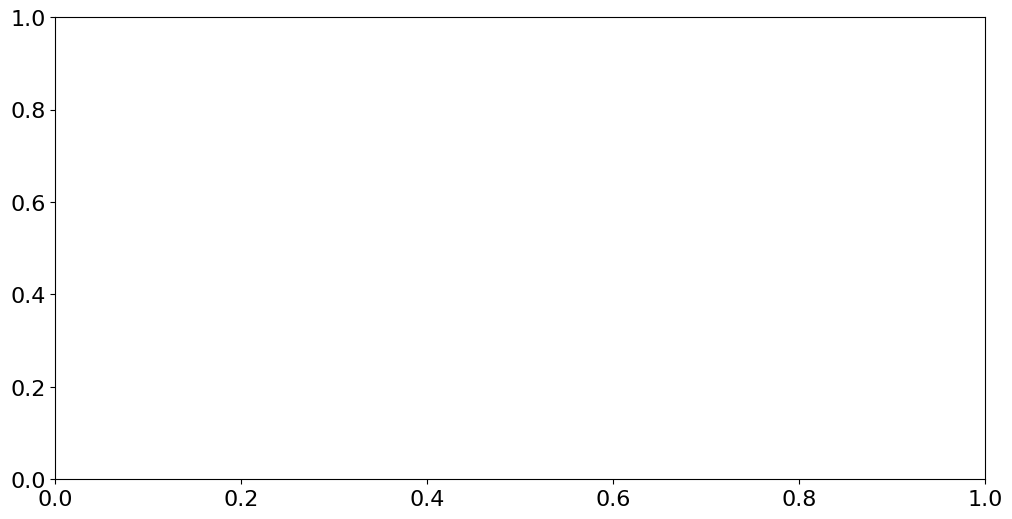

In [62]:
plot_results.schedule(results=results_mincost_3, y_axis='S', component='com1_sold', location='loc5', color='green')

In [ ]:
min(value for key, value in results_mincost_3.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold')

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc2'and key[2]=='truck50_12'and key[3]=='com1_loc1_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc2'and key[2]=='truck50_12'and key[3]=='com1_loc1_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc2'and key[2]=='truck50_12'and key[3]=='com1_loc1_out'))), list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc2'and key[2]=='truck50_12'and key[3]=='com1_loc1_out'), label='Min 86', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc1 and loc2 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc3'and key[2]=='truck30_13'and key[3]=='com1_loc1_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc3'and key[2]=='truck30_13'and key[3]=='com1_loc1_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc3'and key[2]=='truck30_13'and key[3]=='com1_loc1_out'))), list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc3'and key[2]=='truck30_13'and key[3]=='com1_loc1_out'), label='Min 86', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc1 and loc2 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc4'and key[2]=='truck50_24'and key[3]=='com1_loc2_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc4'and key[2]=='truck50_24'and key[3]=='com1_loc2_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc4'and key[2]=='truck50_24'and key[3]=='com1_loc2_out'))), list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc4'and key[2]=='truck50_24'and key[3]=='com1_loc2_out'), label='Min 86', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc2 and loc4 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc5'and key[2]=='truck30_25'and key[3]=='com1_loc2_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc5'and key[2]=='truck30_25'and key[3]=='com1_loc2_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc5'and key[2]=='truck30_25'and key[3]=='com1_loc2_out'))), list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc5'and key[2]=='truck30_25'and key[3]=='com1_loc2_out'), label='Min 82', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc2 and loc5 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc3' and key[1]=='loc4'and key[2]=='truck20_34'and key[3]=='com1_loc3_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc3' and key[1]=='loc4'and key[2]=='truck20_34'and key[3]=='com1_loc3_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc3' and key[1]=='loc4'and key[2]=='truck20_34'and key[3]=='com1_loc3_out'))), list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc3' and key[1]=='loc4'and key[2]=='truck20_34'and key[3]=='com1_loc3_out'), label='Min 86', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc3 and loc4 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc5'and key[2]=='truck100_45'and key[3]=='com1_loc4_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc5'and key[2]=='truck100_45'and key[3]=='com1_loc4_out'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc5'and key[2]=='truck100_45'and key[3]=='com1_loc4_out'))), list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc5'and key[2]=='truck100_45'and key[3]=='com1_loc4_out'), label='67 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc4 and loc5 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc7'and key[2]=='truck40_47'and key[3]=='com1_loc4_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc7'and key[2]=='truck40_47'and key[3]=='com1_loc4_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc7'and key[2]=='truck40_47'and key[3]=='com1_loc4_out'))), list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc7'and key[2]=='truck40_47'and key[3]=='com1_loc4_out'), label='Min 86', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc4 and loc7 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc6' and key[1]=='loc4'and key[2]=='truck50_64'and key[3]=='com1_loc6_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc6' and key[1]=='loc4'and key[2]=='truck50_64'and key[3]=='com1_loc6_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc6' and key[1]=='loc4'and key[2]=='truck50_64'and key[3]=='com1_loc6_out'))), list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc6' and key[1]=='loc4'and key[2]=='truck50_64'and key[3]=='com1_loc6_out'), label='Min 86', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc6 and loc4 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc7' and key[1]=='loc5'and key[2]=='truck40_75'and key[3]=='com1_loc7_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc7' and key[1]=='loc5'and key[2]=='truck40_75'and key[3]=='com1_loc7_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc7' and key[1]=='loc5'and key[2]=='truck40_75'and key[3]=='com1_loc7_out'))), list(value for key, value in results_mincost_3.output['Exp'].items() if key[0]=='loc7' and key[1]=='loc5'and key[2]=='truck40_75'and key[3]=='com1_loc7_out'), label='Min 86', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc7 and loc5 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc1' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc1' and key[1]=='com1_stored20'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_3.output['Inv'].items() if key[0]=='loc1' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost_3.output['Inv'].items() if key[0]=='loc1' and key[1]=='com1_stored20'), label='82 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc2' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc2' and key[1]=='com1_stored20'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_3.output['Inv'].items() if key[0]=='loc2' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost_3.output['Inv'].items() if key[0]=='loc2' and key[1]=='com1_stored20'), label='82 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 2')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc3' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc3' and key[1]=='com1_stored20'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_3.output['Inv'].items() if key[0]=='loc3' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost_3.output['Inv'].items() if key[0]=='loc3' and key[1]=='com1_stored20'), label='82 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 3')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc4' and key[1]=='com1_stored50'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc4' and key[1]=='com1_stored50'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_3.output['Inv'].items() if key[0]=='loc4' and key[1]=='com1_stored50'))), list(value for key, value in results_mincost_3.output['Inv'].items() if key[0]=='loc4' and key[1]=='com1_stored50'), label='82 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 4')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc5' and key[1]=='com1_stored50'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc5' and key[1]=='com1_stored50'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_3.output['Inv'].items() if key[0]=='loc5' and key[1]=='com1_stored50'))), list(value for key, value in results_mincost_3.output['Inv'].items() if key[0]=='loc5' and key[1]=='com1_stored50'), label='67 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 5')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_stored10'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_stored10'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_3.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_stored10'))), list(value for key, value in results_mincost_3.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_stored10'), label='82 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 6')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_stored20'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_3.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost_3.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_stored20'), label='82 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 7')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

In [ ]:
problem_mincost_4 = formulate(scenario=scenario_disruption,
                              constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
                                           Constraints.PRODUCTION, Constraints.INVENTORY, Constraints.DEMAND},
                              demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

min_demand_satisfaction_4 = 0.79
min_demand_dict_4 = {i: {com1_sold: min_demand_satisfaction_4 * 100} if i == loc5 else {com1_sold: 0} for i in locset}

min_demand_4 = min_demand_dict_4
if isinstance(min_demand_4, dict):
    if isinstance(list(min_demand_4.keys())[0], Location):
        try:
            min_demand_4 = {i.name: {
                j.name: min_demand_4[i][j] for j in min_demand_4[i].keys()} for i in min_demand_4.keys()}
        except:
            pass

problem_mincost_4.del_component(constraint_demand2)
problem_mincost_4.constraint_demand2 = constraint_demand2(instance=problem_mincost_4, demand=min_demand_4,
                                                          demand_factor=scenario_disruption.demand_factor,
                                                          demand_scale_level=scenario_disruption.demand_scale_level,
                                                          scheduling_scale_level=scenario_disruption.scheduling_scale_level,
                                                          cluster_wt=None, loc_res_dict=None, sign='geq')

results_mincost_4 = solve(scenario=scenario_disruption, instance=problem_mincost_4, solver='gurobi', name='MILP')

In [ ]:
plot_results.schedule(results=results_mincost_4, y_axis='S', component='com1_sold', location='loc5', color='green')

In [ ]:
min(value for key, value in results_mincost_4.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold')

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if
                       key[0] == 'loc1' and key[1] == 'loc2' and key[2] == 'truck50_12' and key[
                           3] == 'com1_loc1_out'))), list(
    value for key, value in results_mincost.output['Exp'].items() if
    key[0] == 'loc1' and key[1] == 'loc2' and key[2] == 'truck50_12' and key[3] == 'com1_loc1_out'), label='No Min',
        color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_4.output['Exp'].items() if
                       key[0] == 'loc1' and key[1] == 'loc2' and key[2] == 'truck50_12' and key[
                           3] == 'com1_loc1_out'))), list(
    value for key, value in results_mincost_4.output['Exp'].items() if
    key[0] == 'loc1' and key[1] == 'loc2' and key[2] == 'truck50_12' and key[3] == 'com1_loc1_out'), label='Min 79',
        color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc1 and loc2 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if
                       key[0] == 'loc1' and key[1] == 'loc3' and key[2] == 'truck30_13' and key[
                           3] == 'com1_loc1_out'))), list(
    value for key, value in results_mincost.output['Exp'].items() if
    key[0] == 'loc1' and key[1] == 'loc3' and key[2] == 'truck30_13' and key[3] == 'com1_loc1_out'), label='No Min',
        color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_4.output['Exp'].items() if
                       key[0] == 'loc1' and key[1] == 'loc3' and key[2] == 'truck30_13' and key[
                           3] == 'com1_loc1_out'))), list(
    value for key, value in results_mincost_4.output['Exp'].items() if
    key[0] == 'loc1' and key[1] == 'loc3' and key[2] == 'truck30_13' and key[3] == 'com1_loc1_out'), label='Min 79',
        color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc1 and loc3 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if
                       key[0] == 'loc2' and key[1] == 'loc4' and key[2] == 'truck50_24' and key[
                           3] == 'com1_loc2_out'))), list(
    value for key, value in results_mincost.output['Exp'].items() if
    key[0] == 'loc2' and key[1] == 'loc4' and key[2] == 'truck50_24' and key[3] == 'com1_loc2_out'), label='No Min',
        color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_4.output['Exp'].items() if
                       key[0] == 'loc2' and key[1] == 'loc4' and key[2] == 'truck50_24' and key[
                           3] == 'com1_loc2_out'))), list(
    value for key, value in results_mincost_4.output['Exp'].items() if
    key[0] == 'loc2' and key[1] == 'loc4' and key[2] == 'truck50_24' and key[3] == 'com1_loc2_out'), label='Min 79',
        color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc2 and loc4 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if
                       key[0] == 'loc2' and key[1] == 'loc5' and key[2] == 'truck30_25' and key[
                           3] == 'com1_loc2_out'))), list(
    value for key, value in results_mincost.output['Exp'].items() if
    key[0] == 'loc2' and key[1] == 'loc5' and key[2] == 'truck30_25' and key[3] == 'com1_loc2_out'), label='No Min',
        color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_4.output['Exp'].items() if
                       key[0] == 'loc2' and key[1] == 'loc5' and key[2] == 'truck30_25' and key[
                           3] == 'com1_loc2_out'))), list(
    value for key, value in results_mincost_4.output['Exp'].items() if
    key[0] == 'loc2' and key[1] == 'loc5' and key[2] == 'truck30_25' and key[3] == 'com1_loc2_out'), label='Min 79',
        color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc2 and loc5 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if
                       key[0] == 'loc3' and key[1] == 'loc4' and key[2] == 'truck20_34' and key[
                           3] == 'com1_loc3_out'))), list(
    value for key, value in results_mincost.output['Exp'].items() if
    key[0] == 'loc3' and key[1] == 'loc4' and key[2] == 'truck20_34' and key[3] == 'com1_loc3_out'), label='No Min',
        color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_4.output['Exp'].items() if
                       key[0] == 'loc3' and key[1] == 'loc4' and key[2] == 'truck20_34' and key[
                           3] == 'com1_loc3_out'))), list(
    value for key, value in results_mincost_4.output['Exp'].items() if
    key[0] == 'loc3' and key[1] == 'loc4' and key[2] == 'truck20_34' and key[3] == 'com1_loc3_out'), label='Min 79',
        color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc3 and loc4 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if
                       key[0] == 'loc4' and key[1] == 'loc5' and key[2] == 'truck100_45' and key[
                           3] == 'com1_loc4_out'))), list(
    value for key, value in results_mincost.output['Exp'].items() if
    key[0] == 'loc4' and key[1] == 'loc5' and key[2] == 'truck100_45' and key[3] == 'com1_loc4_out'), label='No Min',
        color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_4.output['Exp'].items() if
                       key[0] == 'loc4' and key[1] == 'loc5' and key[2] == 'truck100_45' and key[
                           3] == 'com1_loc4_out'))), list(
    value for key, value in results_mincost_4.output['Exp'].items() if
    key[0] == 'loc4' and key[1] == 'loc5' and key[2] == 'truck100_45' and key[3] == 'com1_loc4_out'), label='79 Min',
        color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc4 and loc5 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if
                       key[0] == 'loc4' and key[1] == 'loc7' and key[2] == 'truck40_47' and key[
                           3] == 'com1_loc4_out'))), list(
    value for key, value in results_mincost.output['Exp'].items() if
    key[0] == 'loc4' and key[1] == 'loc7' and key[2] == 'truck40_47' and key[3] == 'com1_loc4_out'), label='No Min',
        color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_4.output['Exp'].items() if
                       key[0] == 'loc4' and key[1] == 'loc7' and key[2] == 'truck40_47' and key[
                           3] == 'com1_loc4_out'))), list(
    value for key, value in results_mincost_4.output['Exp'].items() if
    key[0] == 'loc4' and key[1] == 'loc7' and key[2] == 'truck40_47' and key[3] == 'com1_loc4_out'), label='Min 79',
        color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc4 and loc7 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if
                       key[0] == 'loc6' and key[1] == 'loc4' and key[2] == 'truck50_64' and key[
                           3] == 'com1_loc6_out'))), list(
    value for key, value in results_mincost.output['Exp'].items() if
    key[0] == 'loc6' and key[1] == 'loc4' and key[2] == 'truck50_64' and key[3] == 'com1_loc6_out'), label='No Min',
        color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_4.output['Exp'].items() if
                       key[0] == 'loc6' and key[1] == 'loc4' and key[2] == 'truck50_64' and key[
                           3] == 'com1_loc6_out'))), list(
    value for key, value in results_mincost_4.output['Exp'].items() if
    key[0] == 'loc6' and key[1] == 'loc4' and key[2] == 'truck50_64' and key[3] == 'com1_loc6_out'), label='Min 79',
        color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc6 and loc4 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if
                       key[0] == 'loc7' and key[1] == 'loc5' and key[2] == 'truck40_75' and key[
                           3] == 'com1_loc7_out'))), list(
    value for key, value in results_mincost.output['Exp'].items() if
    key[0] == 'loc7' and key[1] == 'loc5' and key[2] == 'truck40_75' and key[3] == 'com1_loc7_out'), label='No Min',
        color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_4.output['Exp'].items() if
                       key[0] == 'loc7' and key[1] == 'loc5' and key[2] == 'truck40_75' and key[
                           3] == 'com1_loc7_out'))), list(
    value for key, value in results_mincost_4.output['Exp'].items() if
    key[0] == 'loc7' and key[1] == 'loc5' and key[2] == 'truck40_75' and key[3] == 'com1_loc7_out'), label='Min 79',
        color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc7 and loc5 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(
    value for key, value in results_mincost.output['Inv'].items() if key[0] == 'loc1' and key[1] == 'com1_stored20'))),
        list(value for key, value in results_mincost.output['Inv'].items() if
             key[0] == 'loc1' and key[1] == 'com1_stored20'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_4.output['Inv'].items() if
                       key[0] == 'loc1' and key[1] == 'com1_stored20'))), list(
    value for key, value in results_mincost_4.output['Inv'].items() if key[0] == 'loc1' and key[1] == 'com1_stored20'),
        label='79 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(
    value for key, value in results_mincost.output['Inv'].items() if key[0] == 'loc2' and key[1] == 'com1_stored20'))),
        list(value for key, value in results_mincost.output['Inv'].items() if
             key[0] == 'loc2' and key[1] == 'com1_stored20'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_4.output['Inv'].items() if
                       key[0] == 'loc2' and key[1] == 'com1_stored20'))), list(
    value for key, value in results_mincost_4.output['Inv'].items() if key[0] == 'loc2' and key[1] == 'com1_stored20'),
        label='79 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 2')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(
    value for key, value in results_mincost.output['Inv'].items() if key[0] == 'loc3' and key[1] == 'com1_stored20'))),
        list(value for key, value in results_mincost.output['Inv'].items() if
             key[0] == 'loc3' and key[1] == 'com1_stored20'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_4.output['Inv'].items() if
                       key[0] == 'loc3' and key[1] == 'com1_stored20'))), list(
    value for key, value in results_mincost_4.output['Inv'].items() if key[0] == 'loc3' and key[1] == 'com1_stored20'),
        label='79 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 3')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(
    value for key, value in results_mincost.output['Inv'].items() if key[0] == 'loc4' and key[1] == 'com1_stored50'))),
        list(value for key, value in results_mincost.output['Inv'].items() if
             key[0] == 'loc4' and key[1] == 'com1_stored50'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_4.output['Inv'].items() if
                       key[0] == 'loc4' and key[1] == 'com1_stored50'))), list(
    value for key, value in results_mincost_4.output['Inv'].items() if key[0] == 'loc4' and key[1] == 'com1_stored50'),
        label='79 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 4')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(
    value for key, value in results_mincost.output['Inv'].items() if key[0] == 'loc5' and key[1] == 'com1_stored50'))),
        list(value for key, value in results_mincost.output['Inv'].items() if
             key[0] == 'loc5' and key[1] == 'com1_stored50'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_4.output['Inv'].items() if
                       key[0] == 'loc5' and key[1] == 'com1_stored50'))), list(
    value for key, value in results_mincost_4.output['Inv'].items() if key[0] == 'loc5' and key[1] == 'com1_stored50'),
        label='79 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 5')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(
    value for key, value in results_mincost.output['Inv'].items() if key[0] == 'loc6' and key[1] == 'com1_stored10'))),
        list(value for key, value in results_mincost.output['Inv'].items() if
             key[0] == 'loc6' and key[1] == 'com1_stored10'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_4.output['Inv'].items() if
                       key[0] == 'loc6' and key[1] == 'com1_stored10'))), list(
    value for key, value in results_mincost_4.output['Inv'].items() if key[0] == 'loc6' and key[1] == 'com1_stored10'),
        label='79 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 6')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(
    value for key, value in results_mincost.output['Inv'].items() if key[0] == 'loc7' and key[1] == 'com1_stored20'))),
        list(value for key, value in results_mincost.output['Inv'].items() if
             key[0] == 'loc7' and key[1] == 'com1_stored20'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_4.output['Inv'].items() if
                       key[0] == 'loc7' and key[1] == 'com1_stored20'))), list(
    value for key, value in results_mincost_4.output['Inv'].items() if key[0] == 'loc7' and key[1] == 'com1_stored20'),
        label='79 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 7')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if
                       key[0] == 'loc2' and key[1] == 'loc5' and key[2] == 'truck30_25' and key[
                           3] == 'com1_loc2_out' and (key[5]==9)))), list(
    value for key, value in results_mincost.output['Exp'].items() if
    key[0] == 'loc2' and key[1] == 'loc5' and key[2] == 'truck30_25' and key[3] == 'com1_loc2_out' and (key[5]==9)), label='No Min',
        color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_4.output['Exp'].items() if
                       key[0] == 'loc2' and key[1] == 'loc5' and key[2] == 'truck30_25' and key[
                           3] == 'com1_loc2_out' and (key[5]==9)))), list(
    value for key, value in results_mincost_4.output['Exp'].items() if
    key[0] == 'loc2' and key[1] == 'loc5' and key[2] == 'truck30_25' and key[3] == 'com1_loc2_out' and (key[5]==9)), label='Min 79',
        color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc2 and loc5 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if
                       key[0] == 'loc2' and key[1] == 'loc5' and key[2] == 'truck30_25' and key[
                           3] == 'com1_loc2_out' and (key[5]==4)))), list(
    value for key, value in results_mincost.output['Exp'].items() if
    key[0] == 'loc2' and key[1] == 'loc5' and key[2] == 'truck30_25' and key[3] == 'com1_loc2_out' and (key[5]==4)), label='No Min',
        color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_4.output['Exp'].items() if
                       key[0] == 'loc2' and key[1] == 'loc5' and key[2] == 'truck30_25' and key[
                           3] == 'com1_loc2_out' and (key[5]==4)))), list(
    value for key, value in results_mincost_4.output['Exp'].items() if
    key[0] == 'loc2' and key[1] == 'loc5' and key[2] == 'truck30_25' and key[3] == 'com1_loc2_out' and (key[5]==4)), label='Min 79',
        color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc2 and loc5 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

In [ ]:
max(value for key, value in results_mincost_4.output['Exp'].items() if
                       key[0] == 'loc1' and key[1] == 'loc2' and key[2] == 'truck50_12' and key[
                           3] == 'com1_loc1_out')/100


In [ ]:
obj_0 = results_mincost.output['objective']-sum(value for key, value in results_mincost.output['Demand_penalty'].items() if key[0]=='loc5' and key[1]=='com1_sold')*125
obj_2 = results_mincost_2.output['objective']-sum(value for key, value in results_mincost_2.output['Demand_penalty'].items() if key[0]=='loc5' and key[1]=='com1_sold')*125
obj_3 = results_mincost_3.output['objective']-sum(value for key, value in results_mincost_3.output['Demand_penalty'].items() if key[0]=='loc5' and key[1]=='com1_sold')*125
obj_4 = results_mincost_4.output['objective']-sum(value for key, value in results_mincost_4.output['Demand_penalty'].items() if key[0]=='loc5' and key[1]=='com1_sold')*125

In [ ]:
print(obj_0)

In [ ]:
print(obj_2)

In [ ]:
print(obj_3)

In [ ]:
print(obj_4)

In [ ]:
sum(value for key, value in results_mincost.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')/36000

In [ ]:
min(value for key, value in results_mincost.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')

In [ ]:
sum(value for key, value in results_mincost_4.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')/36000

In [ ]:
min(value for key, value in results_mincost_4.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')

In [ ]:
results_mincost.output['objective']

In [ ]:
problem_mincost.Capex_network.pprint()
problem_mincost.Fopex_network.pprint()
problem_mincost.Vopex_network.pprint()
problem_mincost.Capex_transport_network.pprint()
problem_mincost.Fopex_transport_network.pprint()
problem_mincost.Vopex_transport_network.pprint()

In [ ]:
sum(value for key, value in results_mincost.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')/36000


In [ ]:
min(value for key, value in results_mincost.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')

In [ ]:
results_mincost_4.output['objective']

In [ ]:
problem_mincost_4.Capex_network.pprint()
problem_mincost_4.Fopex_network.pprint()
problem_mincost_4.Vopex_network.pprint()
problem_mincost_4.Capex_transport_network.pprint()
problem_mincost_4.Fopex_transport_network.pprint()
problem_mincost_4.Vopex_transport_network.pprint()